In [1]:
import pymongo

client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["bigdata_project"]
collection = db["food_denormalized"]

In [2]:
if client.server_info():
    print("Successfully connected to MongoDB!")

Successfully connected to MongoDB!


In [3]:
pipeline = [
    {
        '$project': {
            '_id': 1, 
            'description': 1, 
            'nutrients': {
                '$map': {
                    'input': '$nutrients', 
                    'as': 'nutrient', 
                    'in': {
                        'name': '$$nutrient.name', 
                        'unit_name': '$$nutrient.unit_name', 
                        'amountInGrams': {
                            '$switch': {
                                'branches': [
                                    {
                                        'case': {
                                            '$eq': [
                                                '$$nutrient.unit_name', 'G'
                                            ]
                                        }, 
                                        'then': '$$nutrient.amount'
                                    }, {
                                        'case': {
                                            '$eq': [
                                                '$$nutrient.unit_name', 'MG'
                                            ]
                                        }, 
                                        'then': {
                                            '$divide': [
                                                '$$nutrient.amount', 1000
                                            ]
                                        }
                                    }, {
                                        'case': {
                                            '$eq': [
                                                '$$nutrient.unit_name', 'UG'
                                            ]
                                        }, 
                                        'then': {
                                            '$divide': [
                                                '$$nutrient.amount', 1000000
                                            ]
                                        }
                                    }
                                ], 
                                'default': 0
                            }
                        }
                    }
                }
            }
        }
    }, {
        '$unwind': {
            'path': '$nutrients'
        }
    }, {
        '$match': {
            '$and': [
                {
                    'nutrients.amountInGrams': {
                        '$gt': 0
                    }
                }, {
                    'nutrients.name': {
                        '$not': {
                            '$regex': '(?i)(\\:|Ash|\\+|Starch|Carbohydrate, by difference|Carbohydrate, by summation|Total fat|ose|fatty)'
                        }
                    }
                }
            ]
        }
    }, {
        '$group': {
            '_id': '$_id', 
            'description': {
                '$first': '$description'
            }, 
            'nutrients': {
                '$addToSet': '$nutrients'
            }
        }
    }, {
        '$project': {
            '_id': 1, 
            'description': 1, 
            'totalAmountInGrams': {
                '$sum': '$nutrients.amountInGrams'
            }, 
            'nutrients': 1
        }
    }
]

In [4]:
result = collection.aggregate(pipeline)

In [5]:
import re
import matplotlib.pyplot as plt
import random

def clean_description(description):
    cleaned_description = re.sub(r'[\\/*?:"<>|]', '', description)
    return cleaned_description

In [6]:
nutrient_colors = {
    "Water": "blue",
    "Protein": "red",
    "Fat": "green",
    "Carbohydrate": "orange",
    "other": "gray"
}
default_color = "gray"

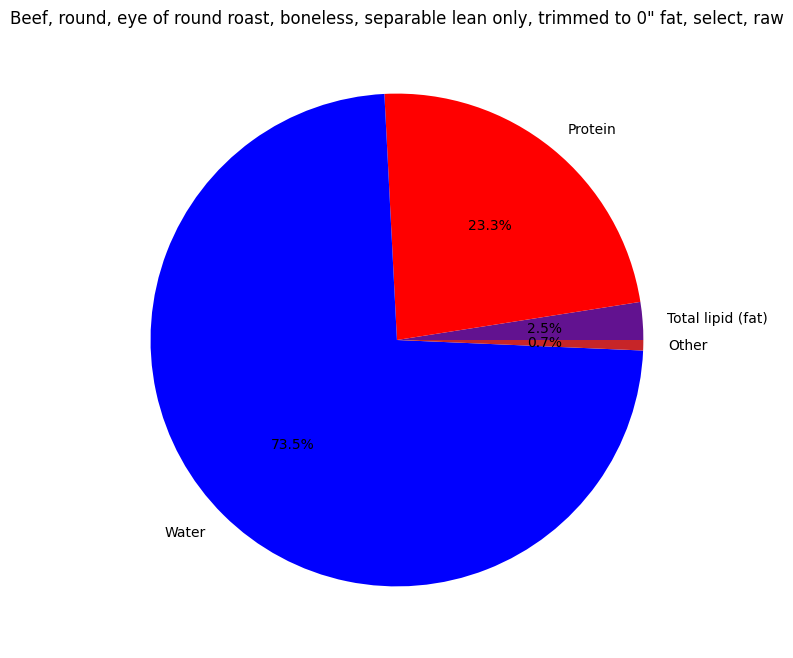

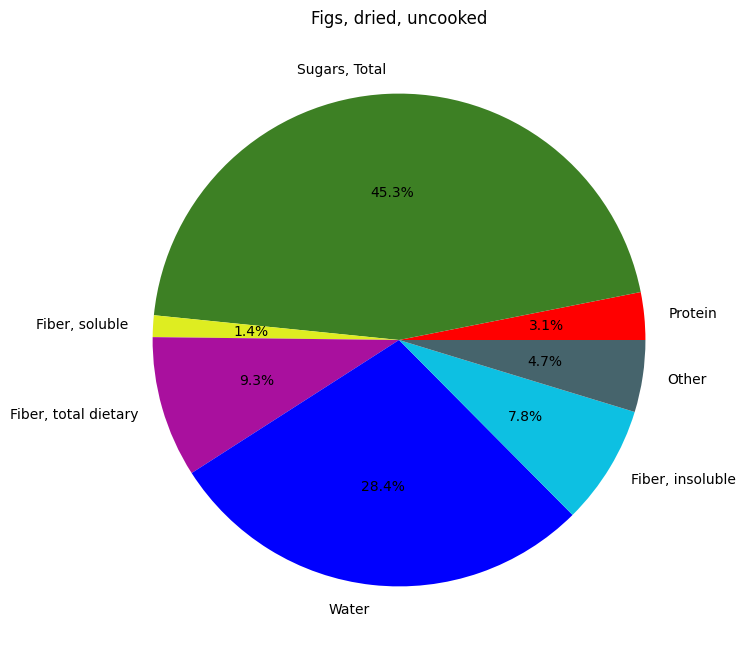

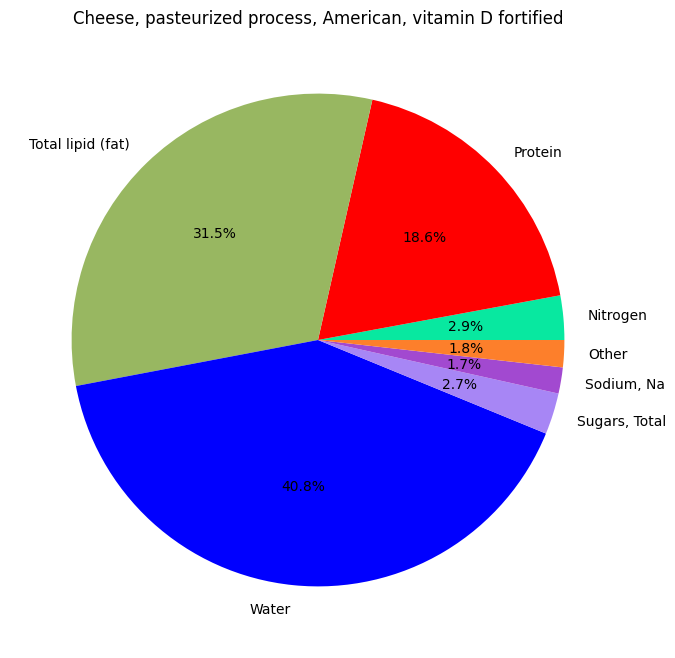

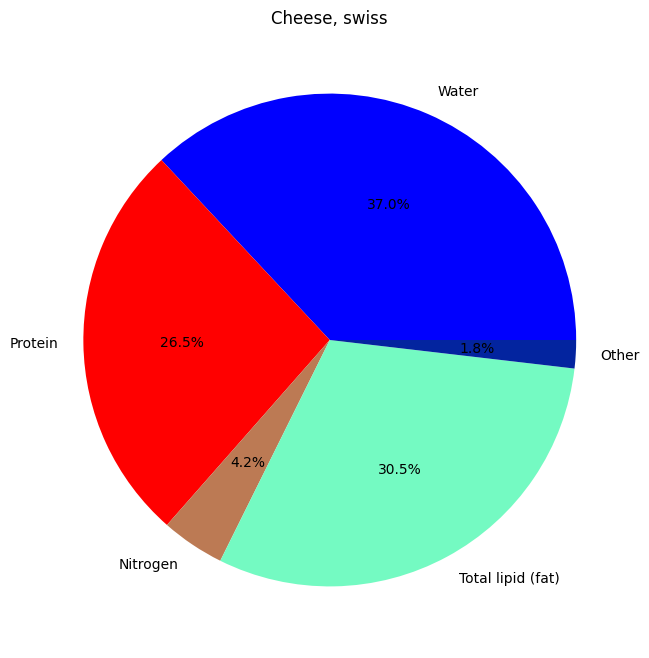

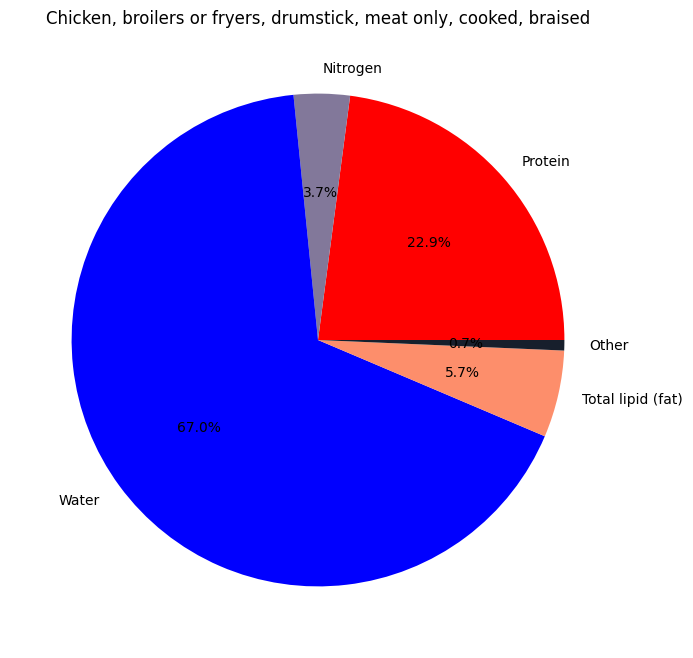

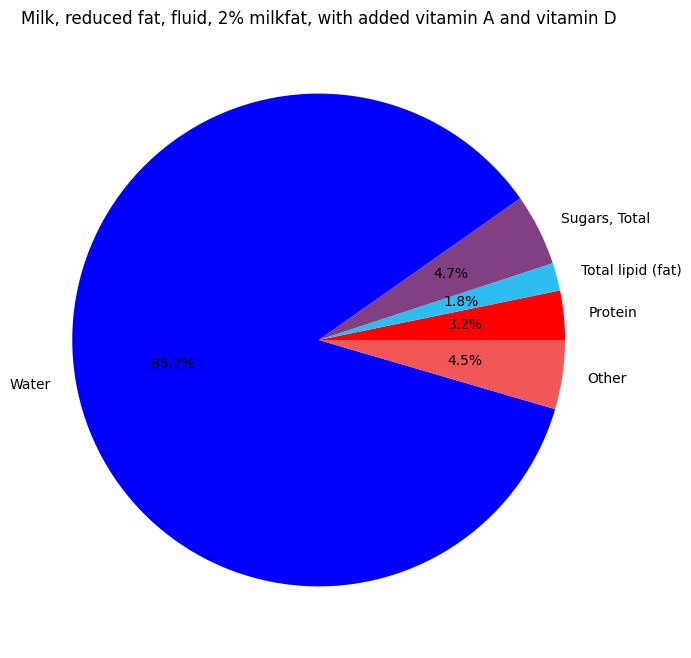

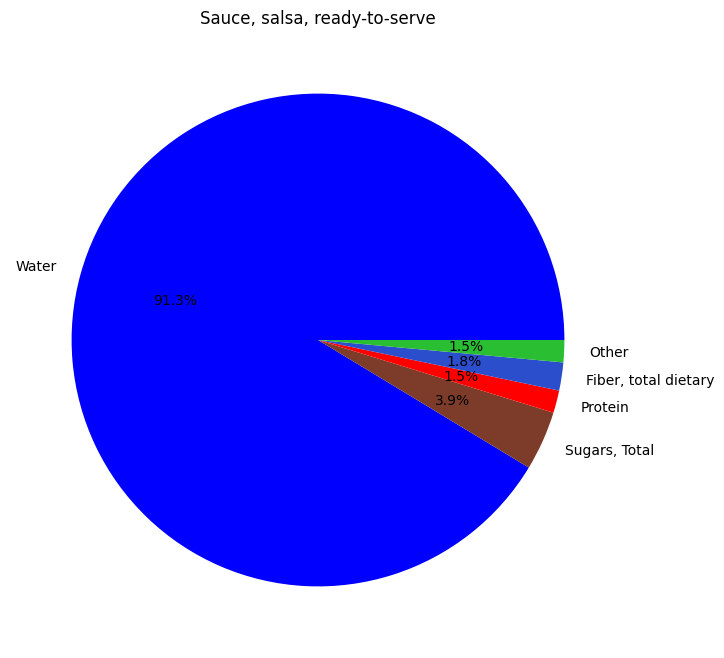

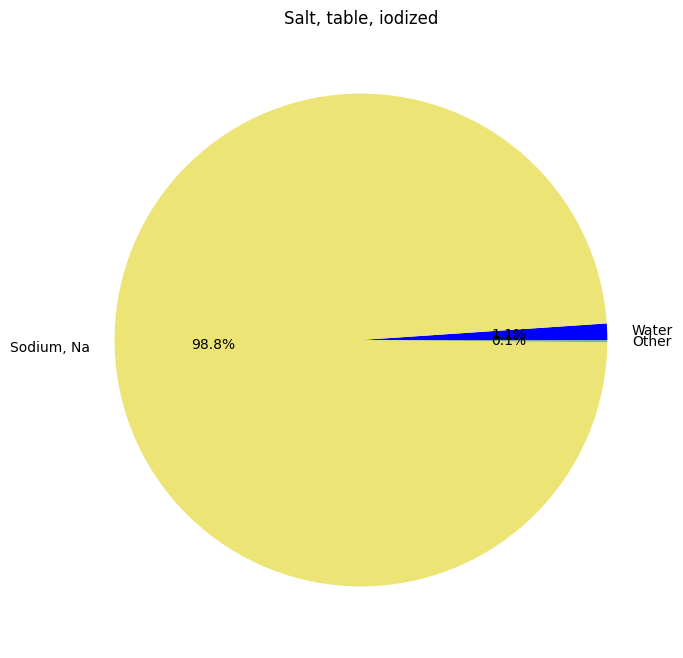

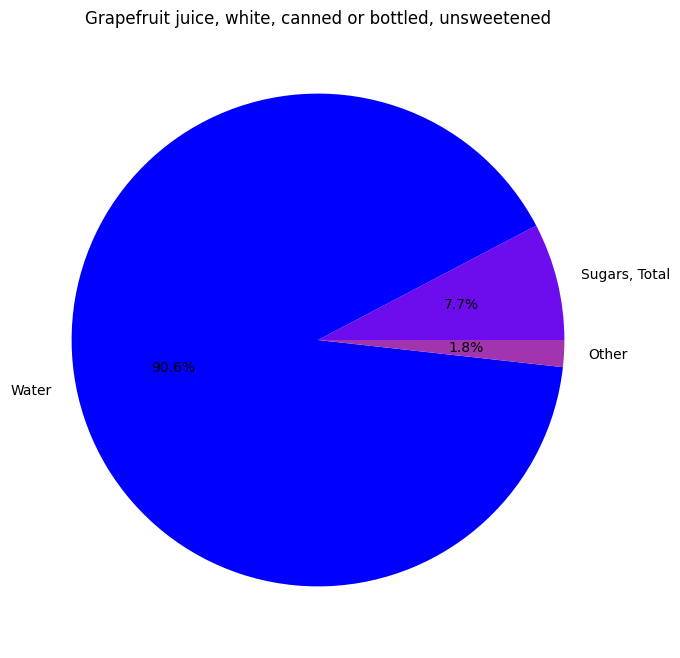

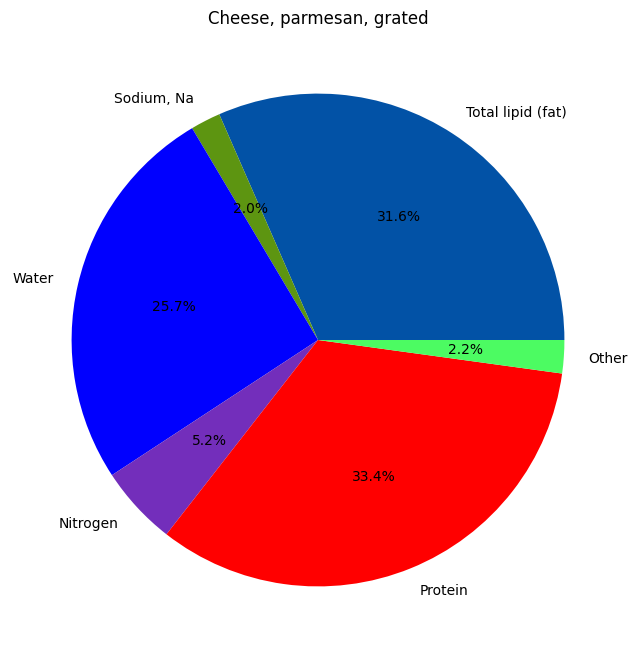

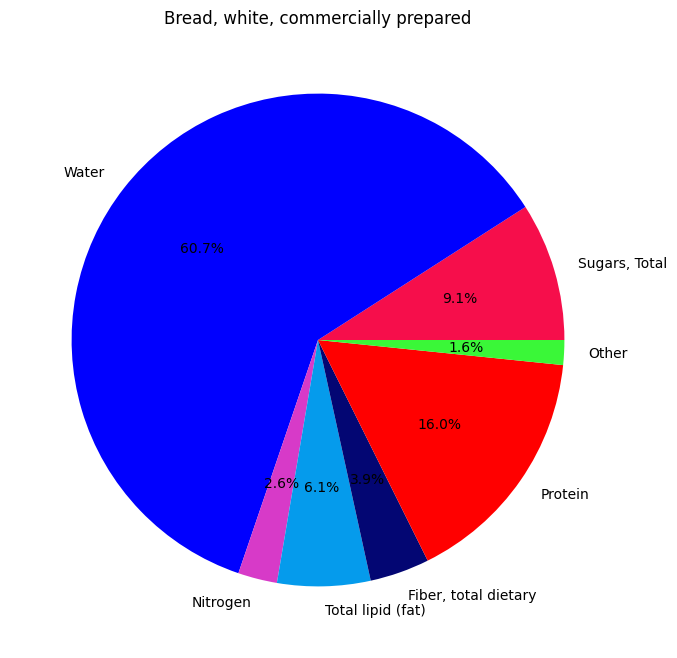

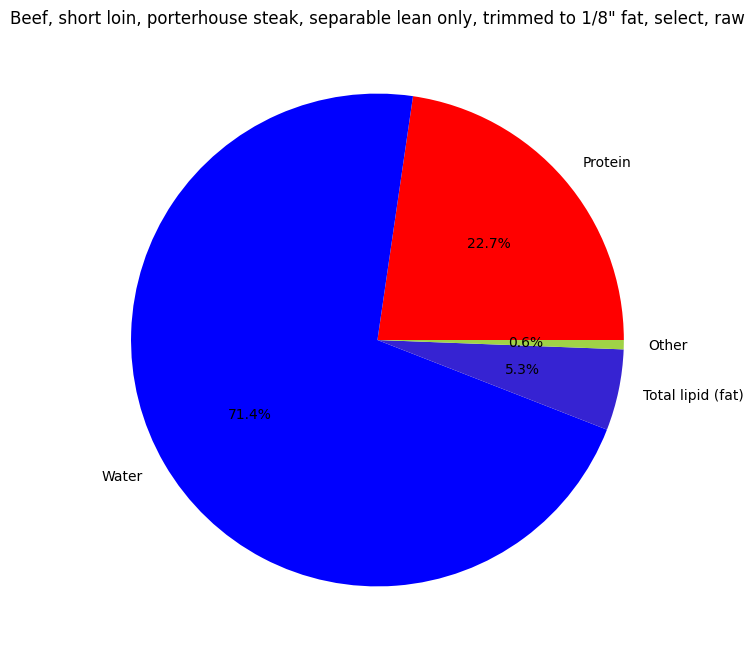

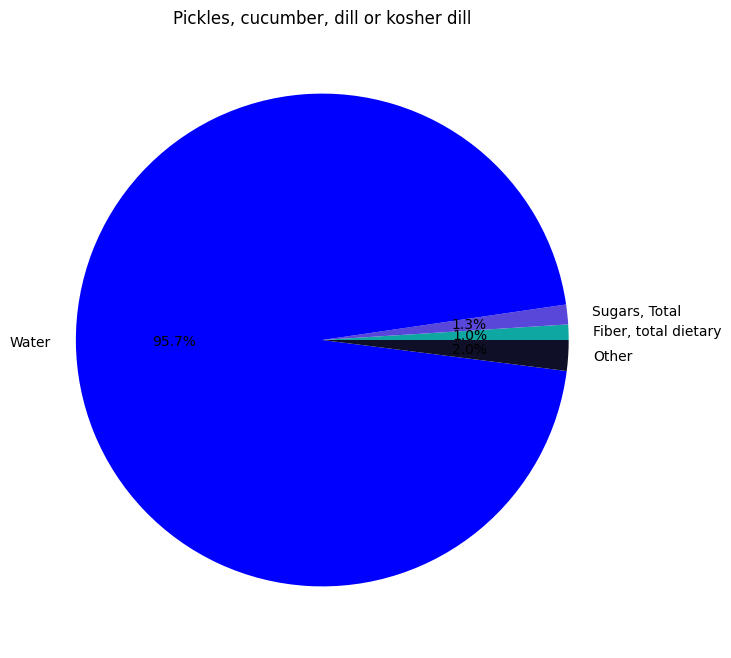

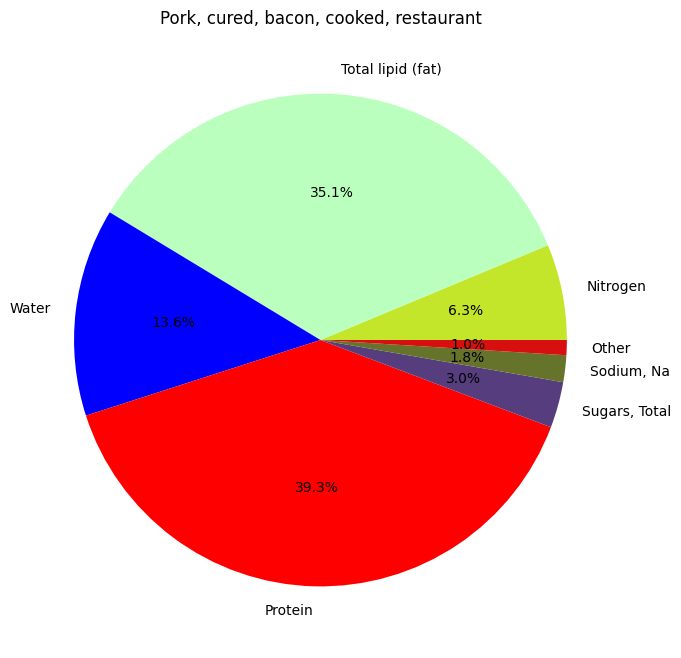

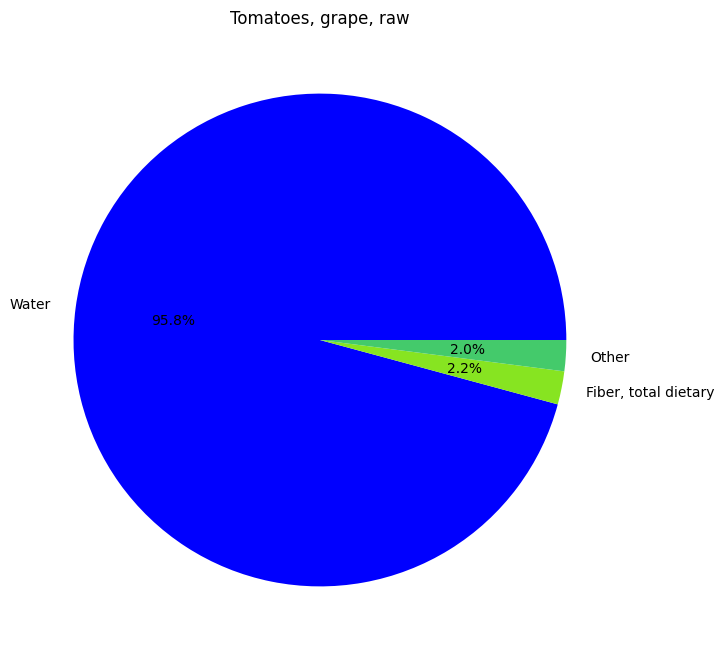

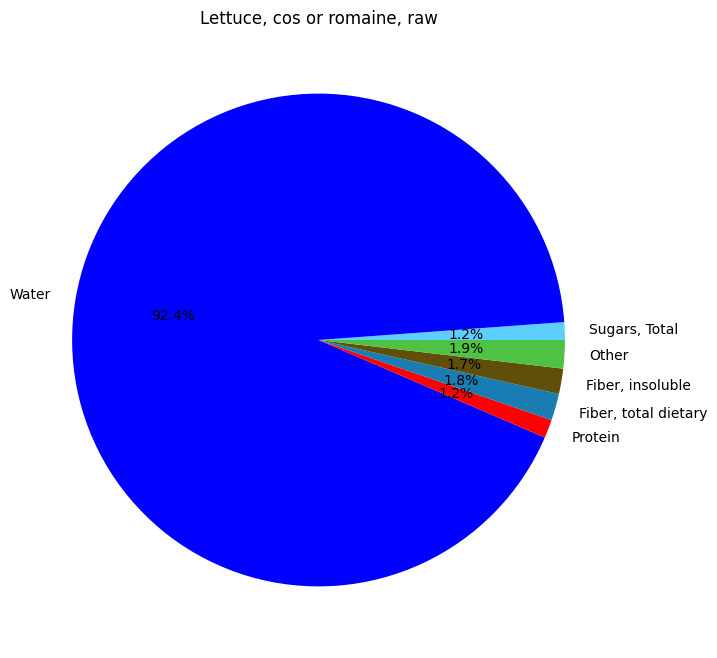

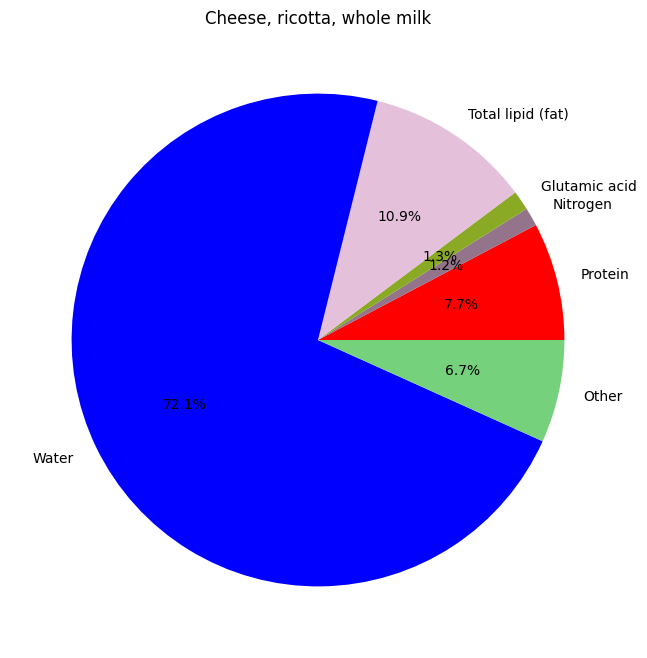

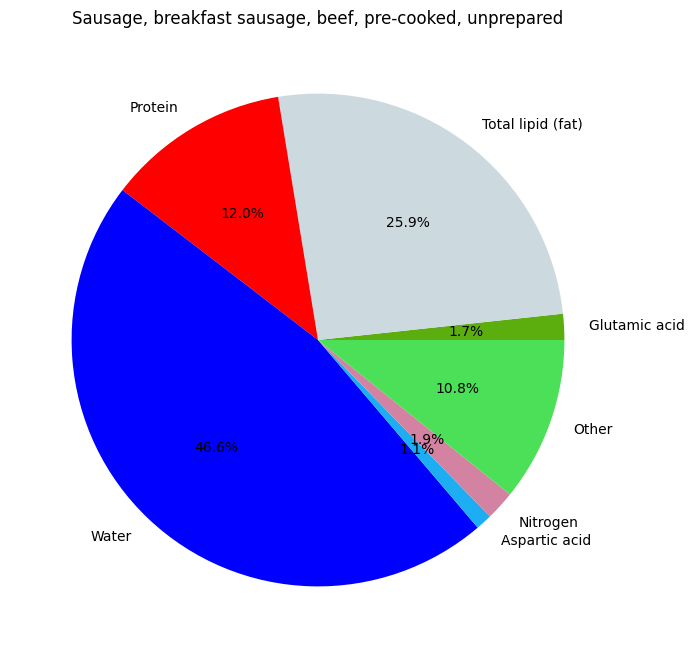

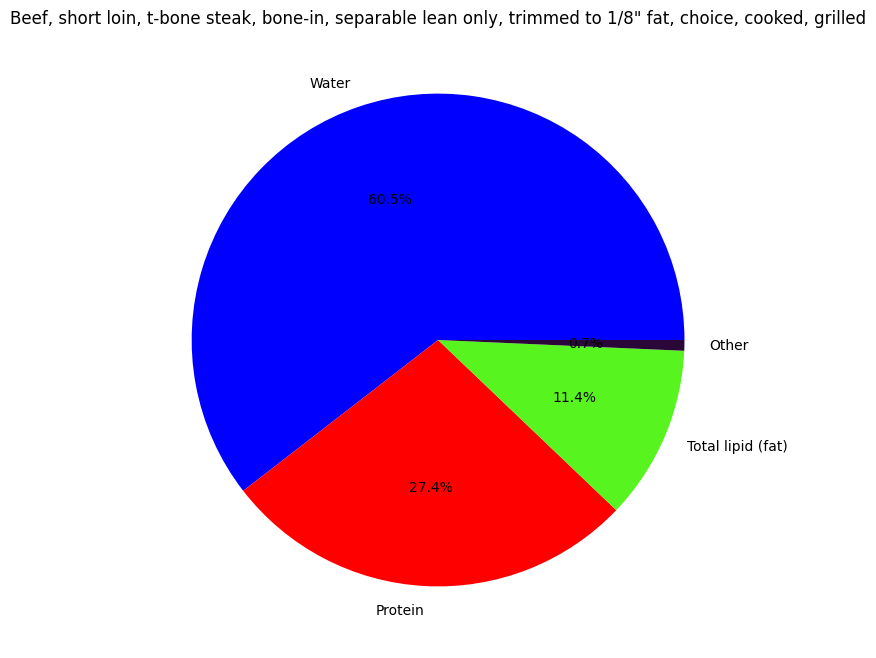

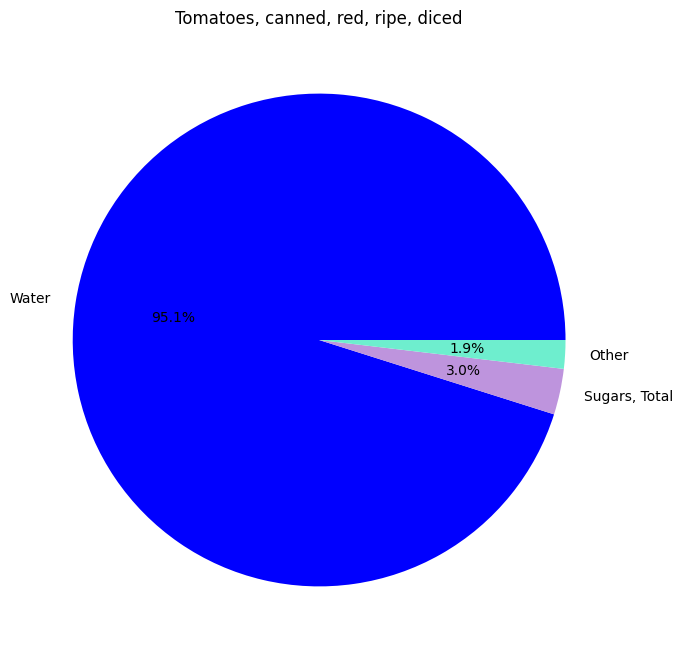

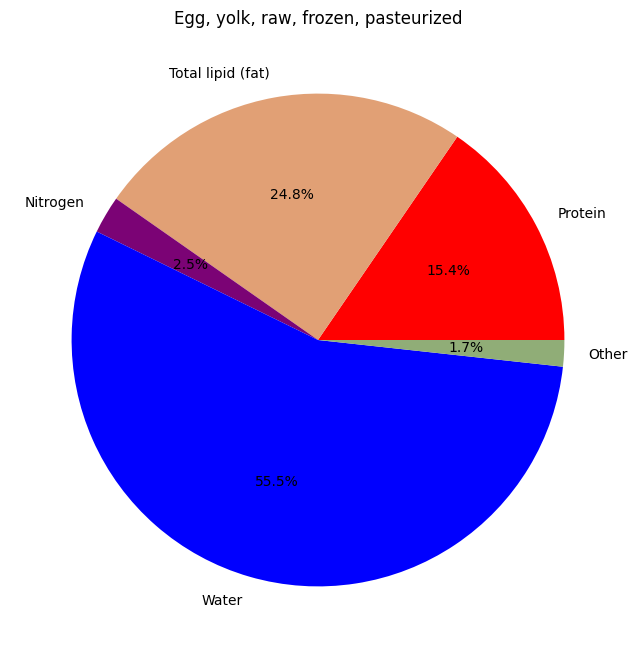

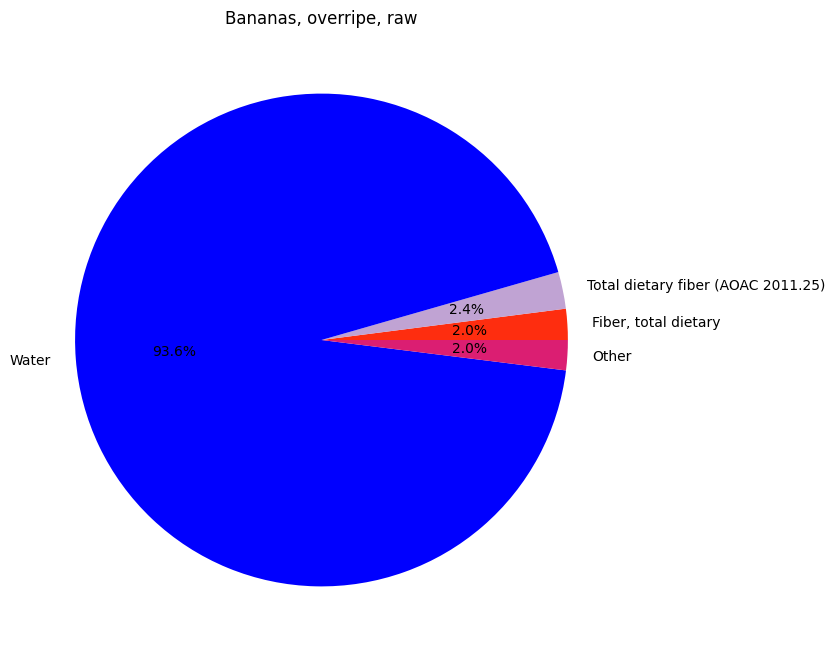

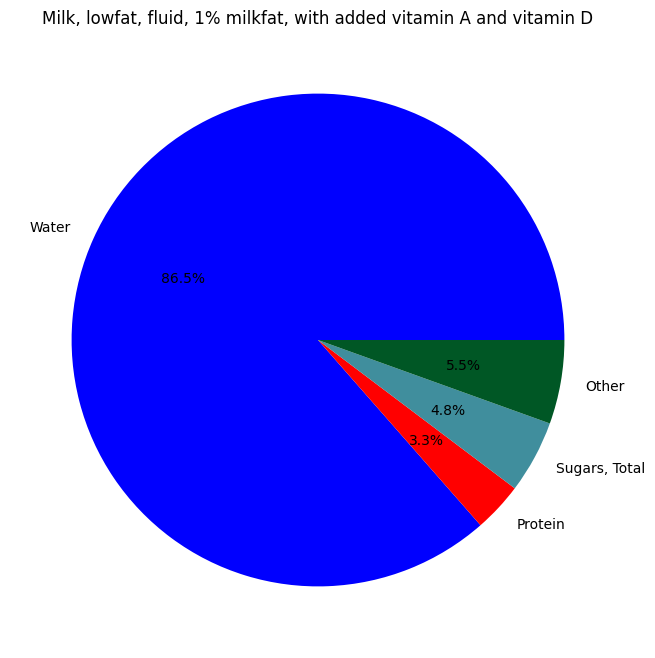

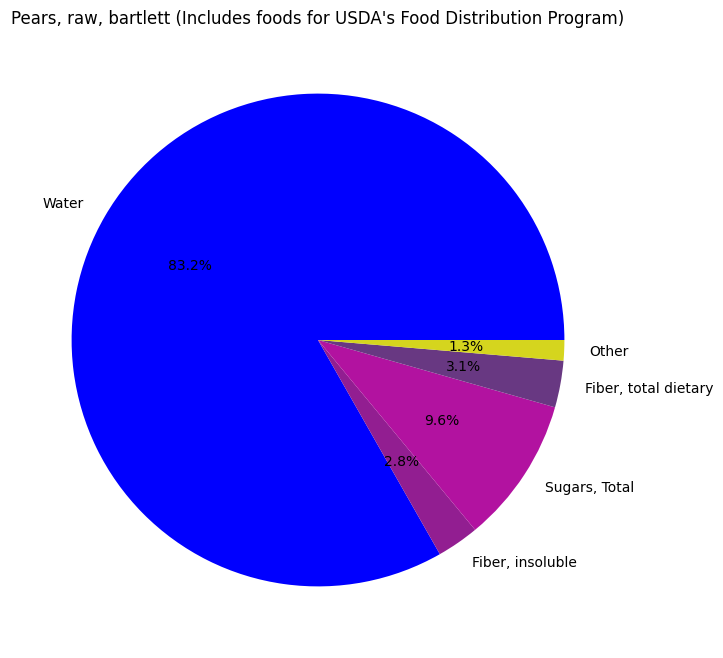

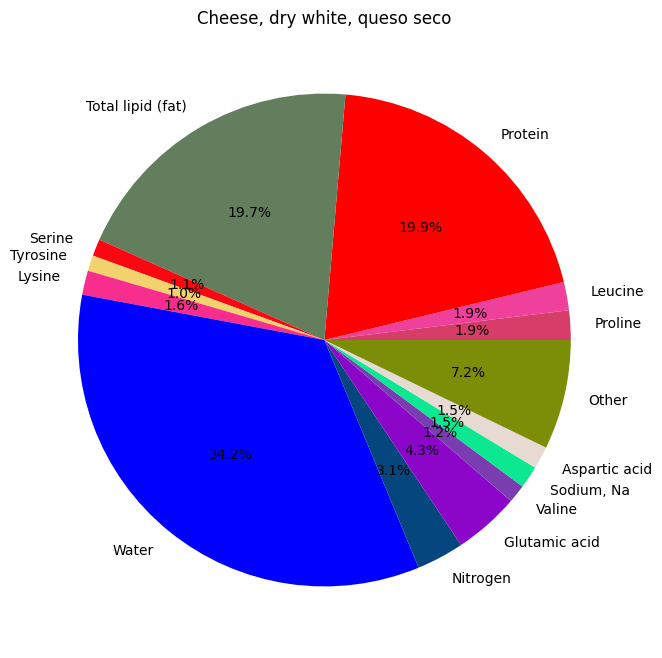

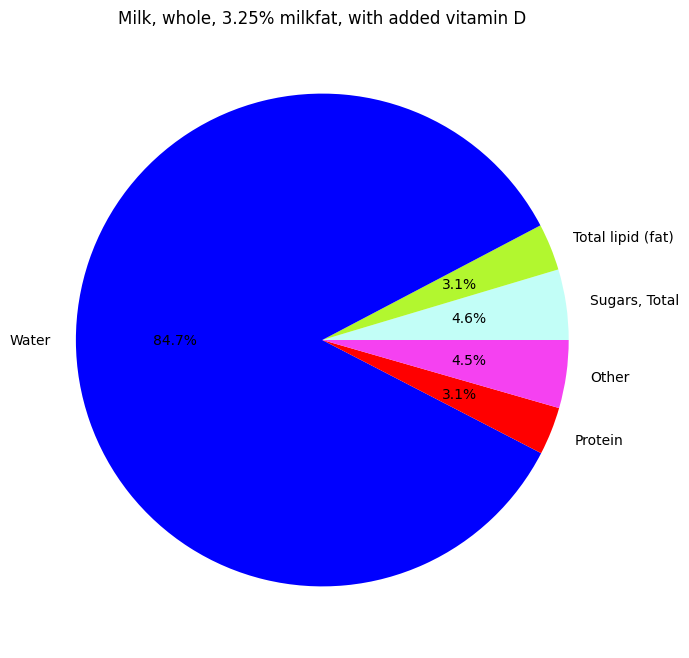

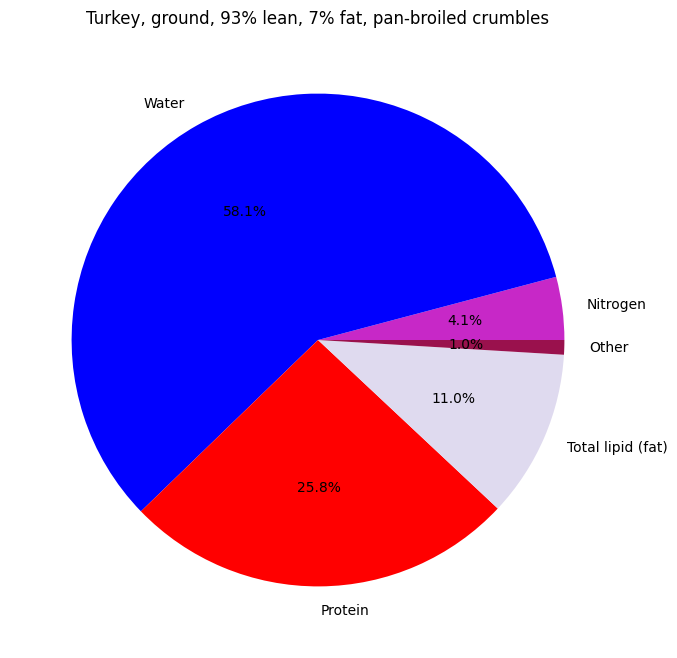

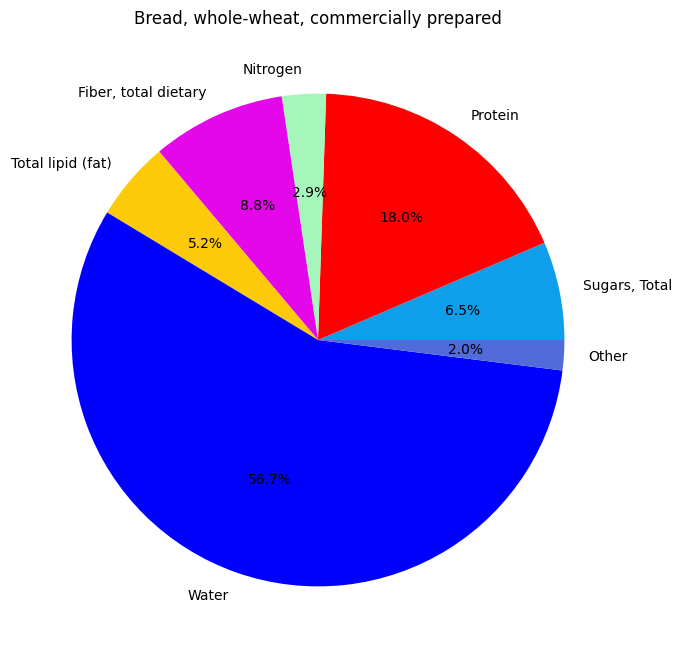

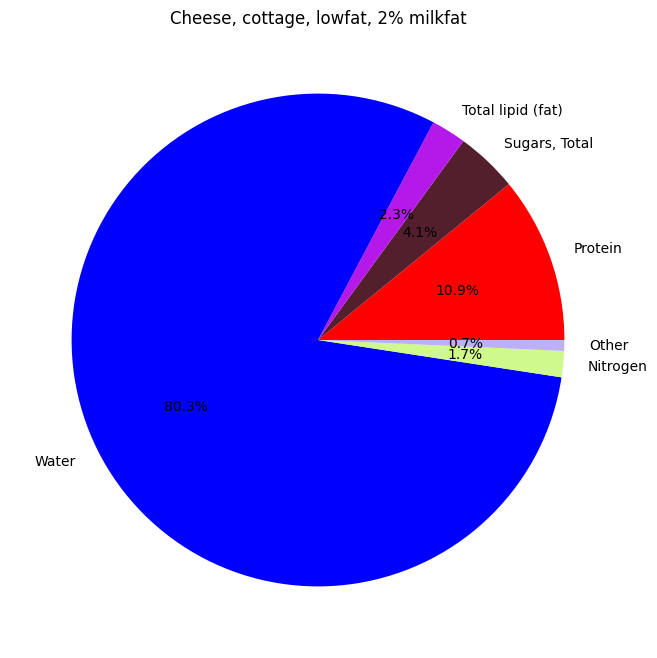

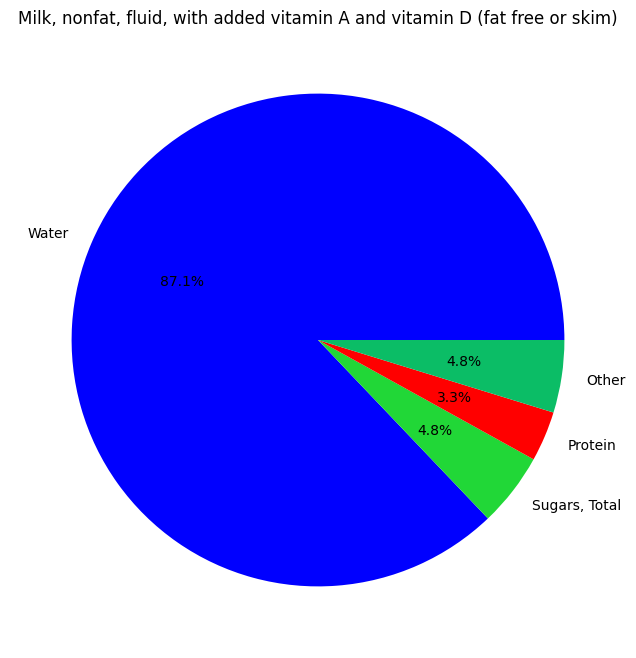

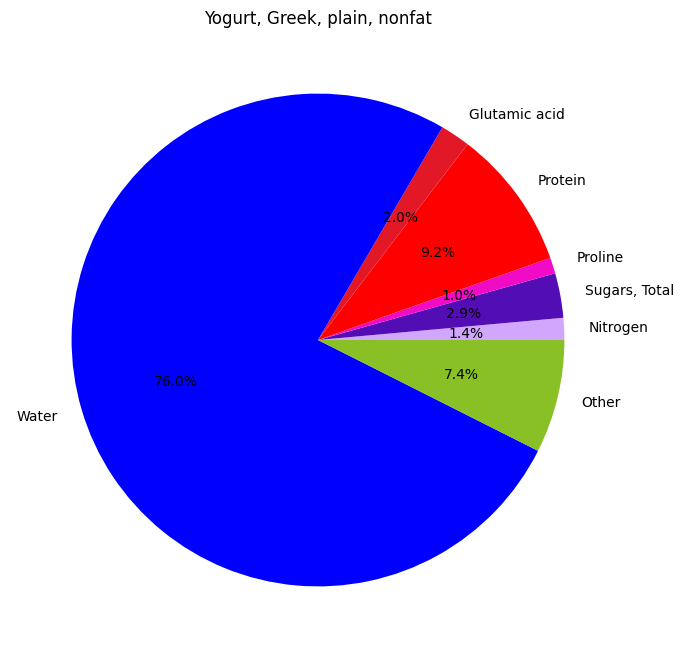

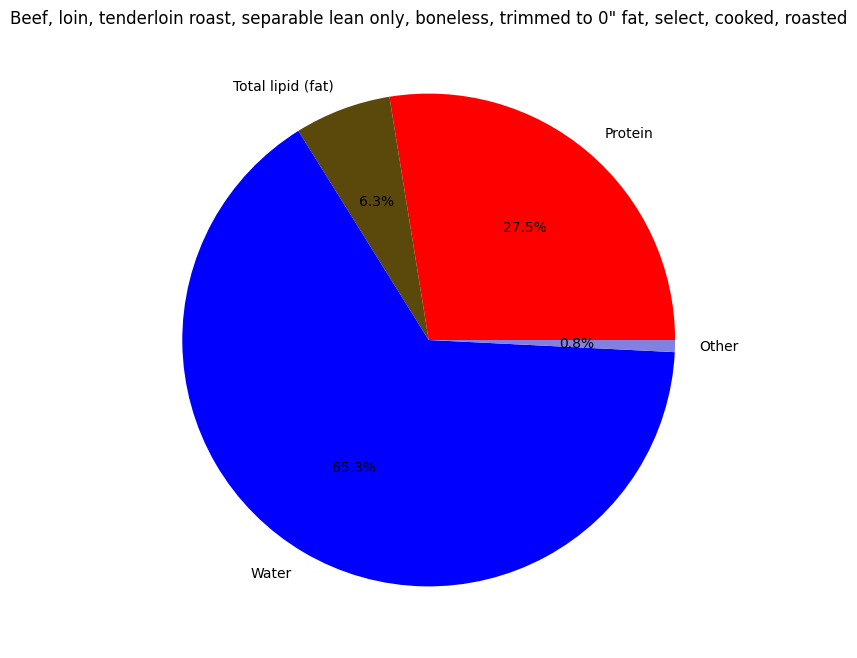

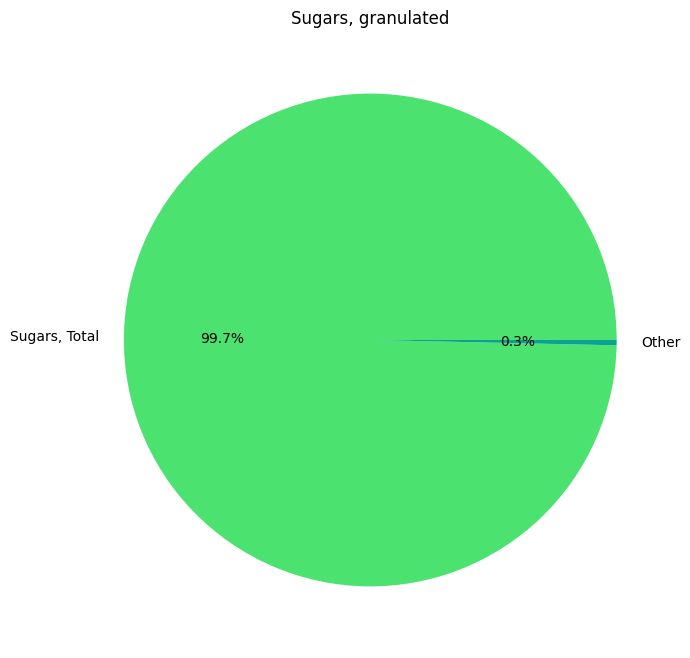

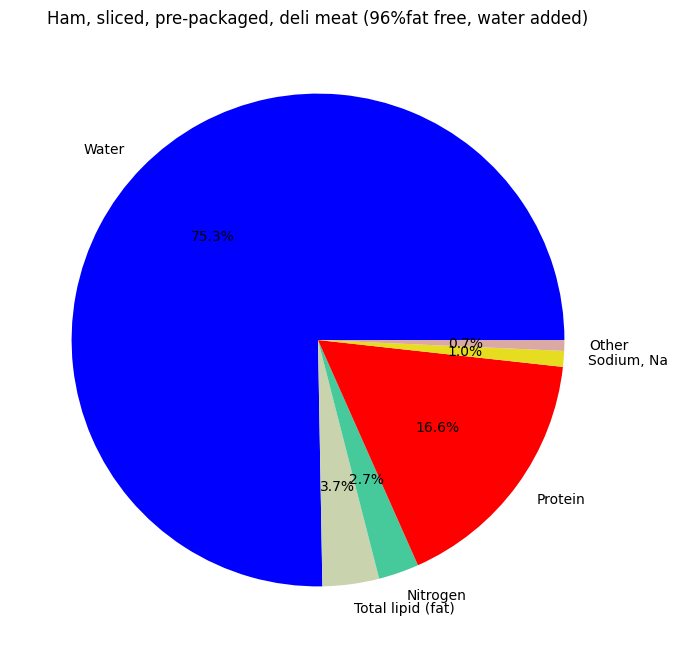

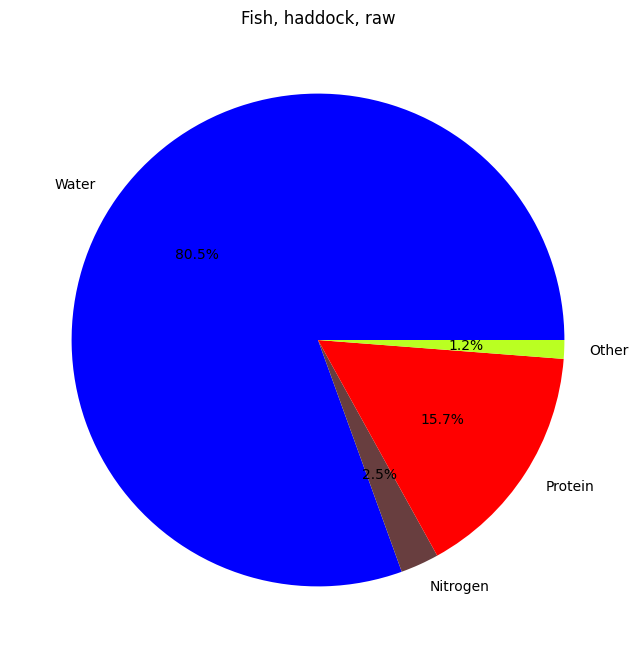

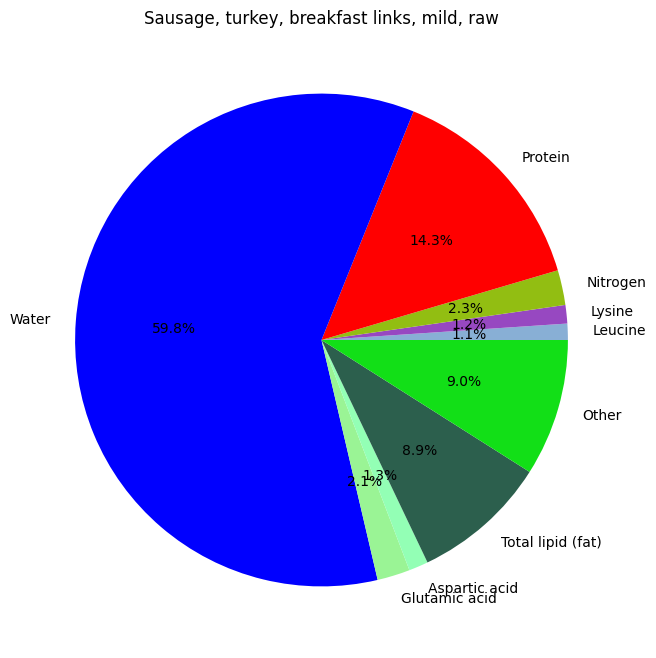

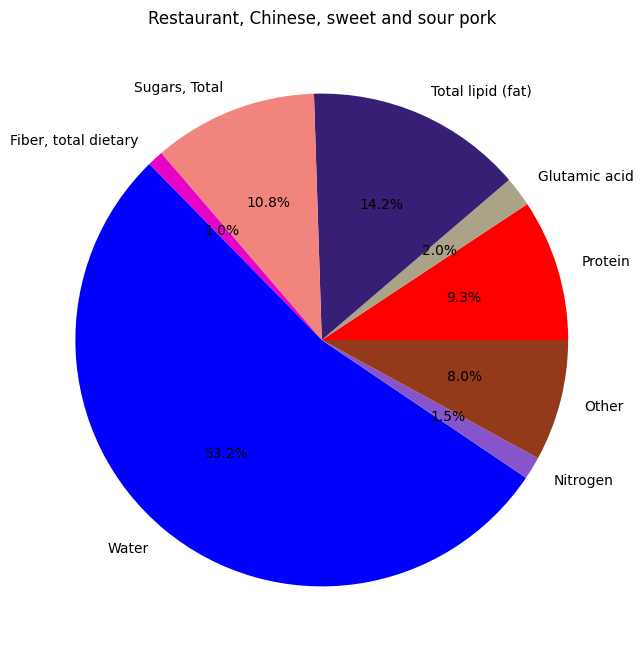

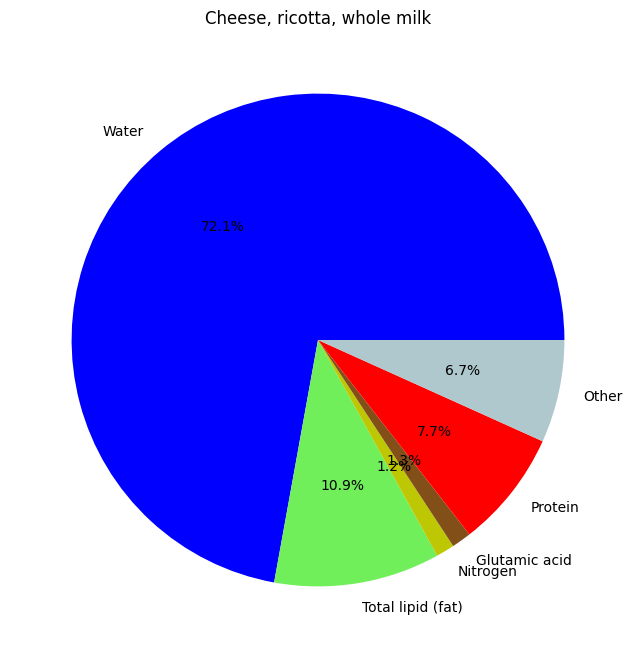

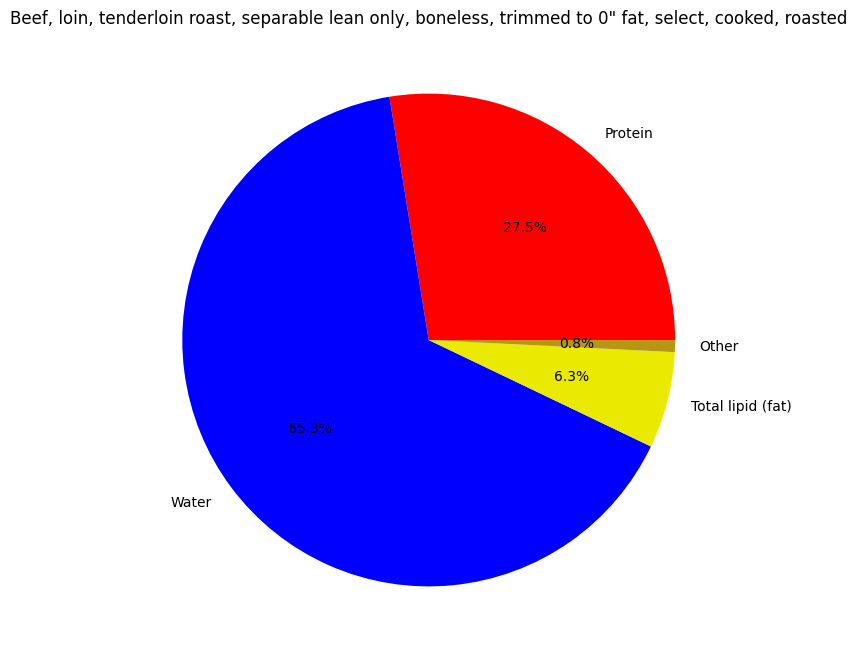

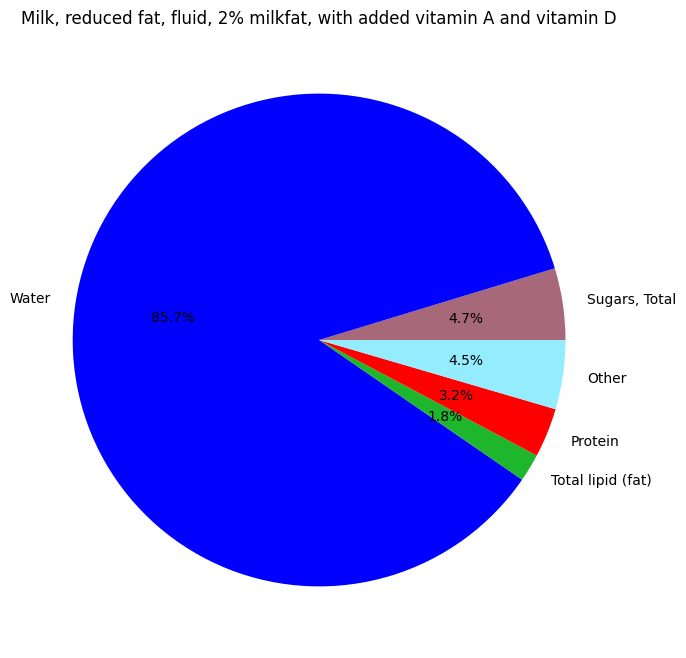

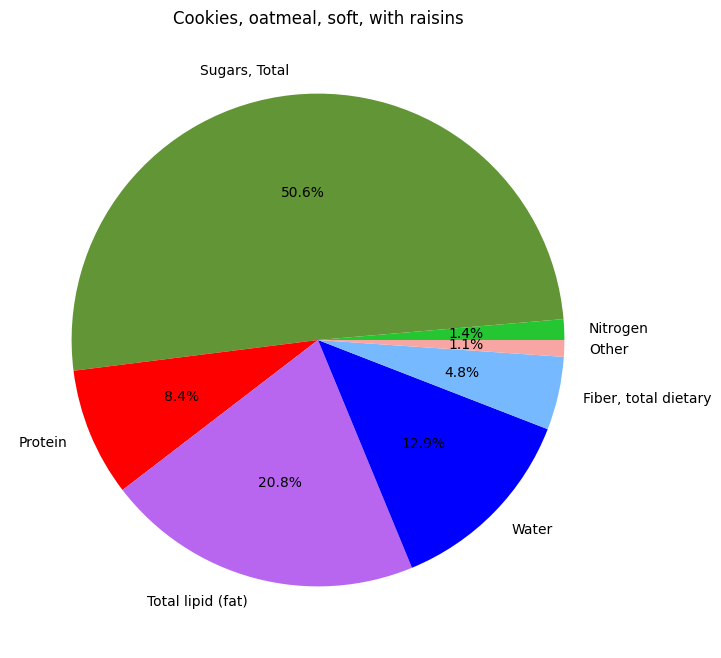

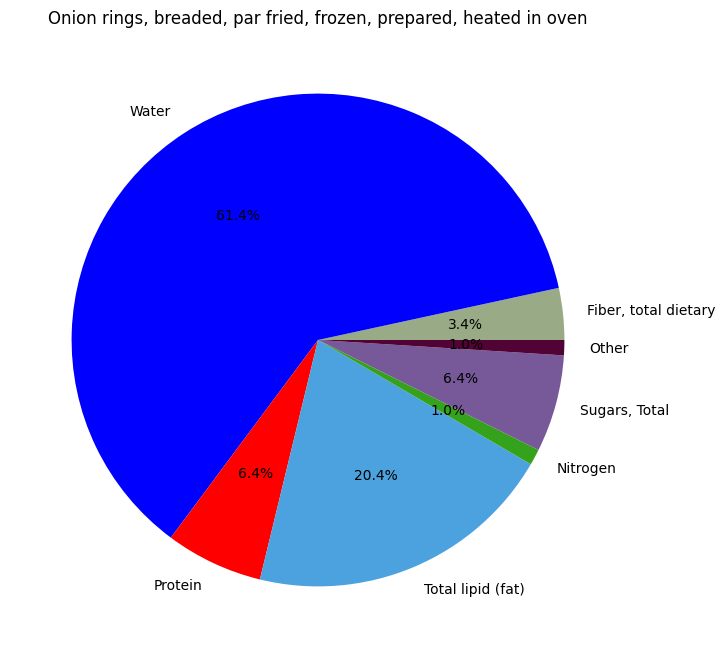

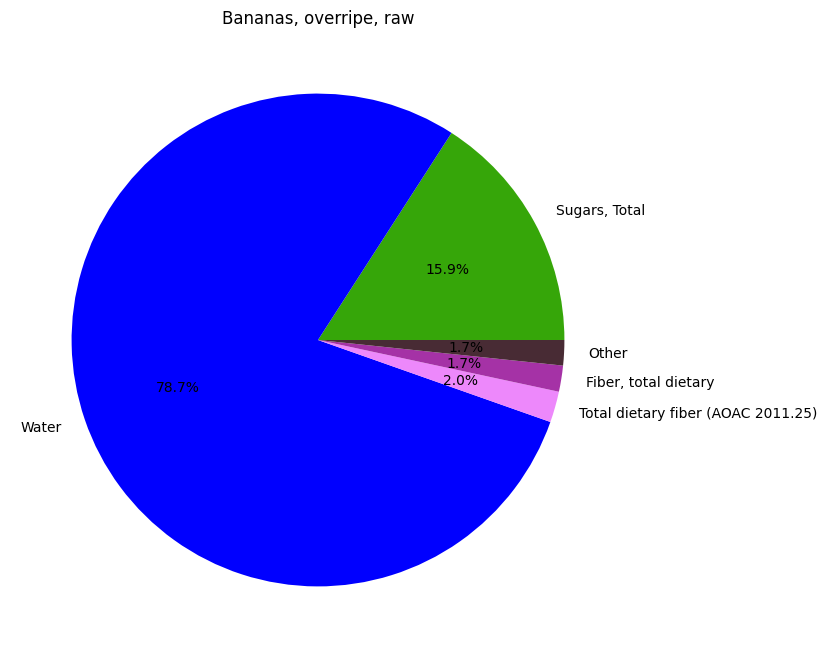

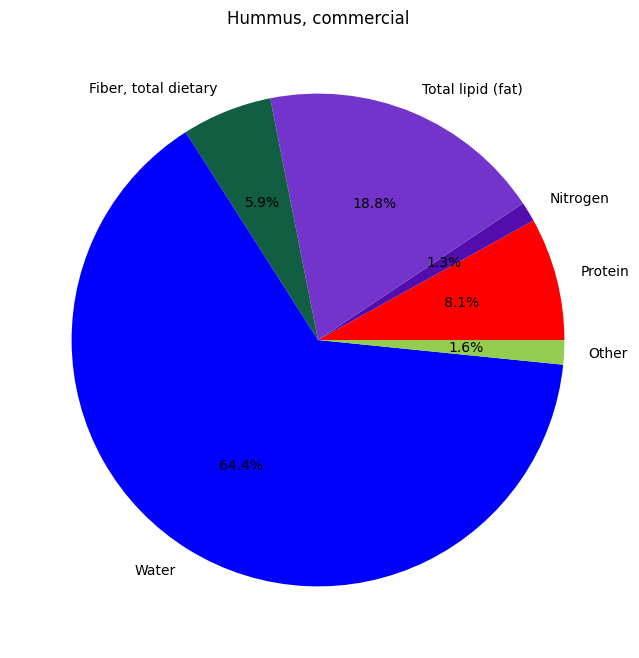

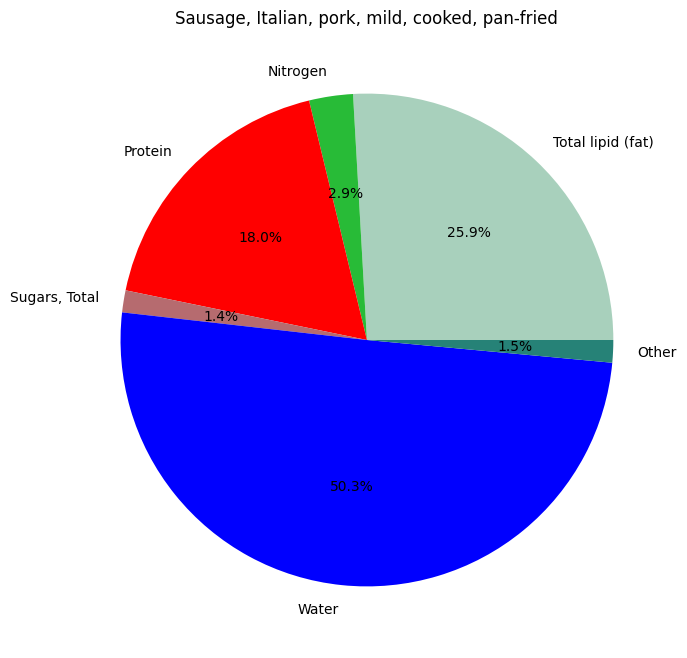

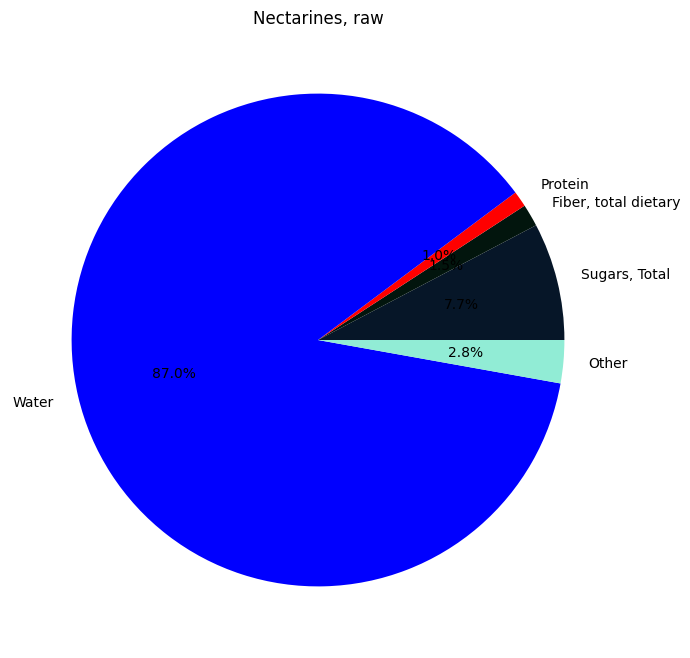

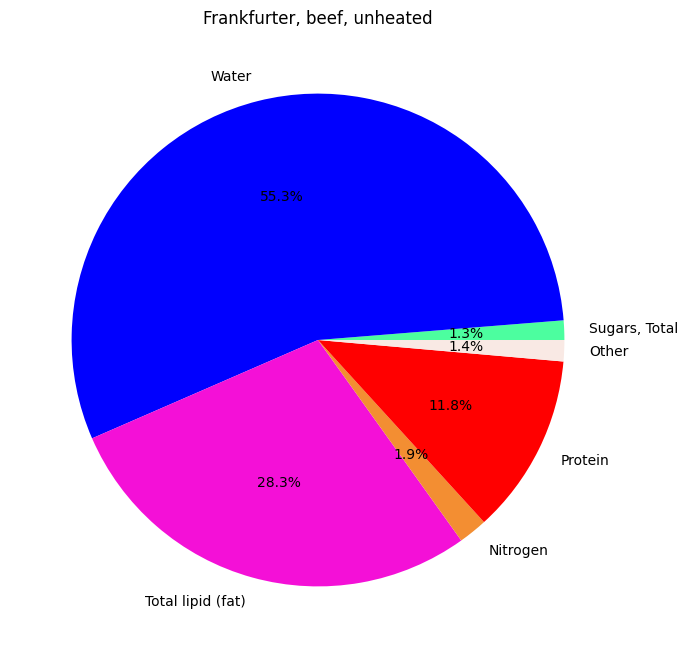

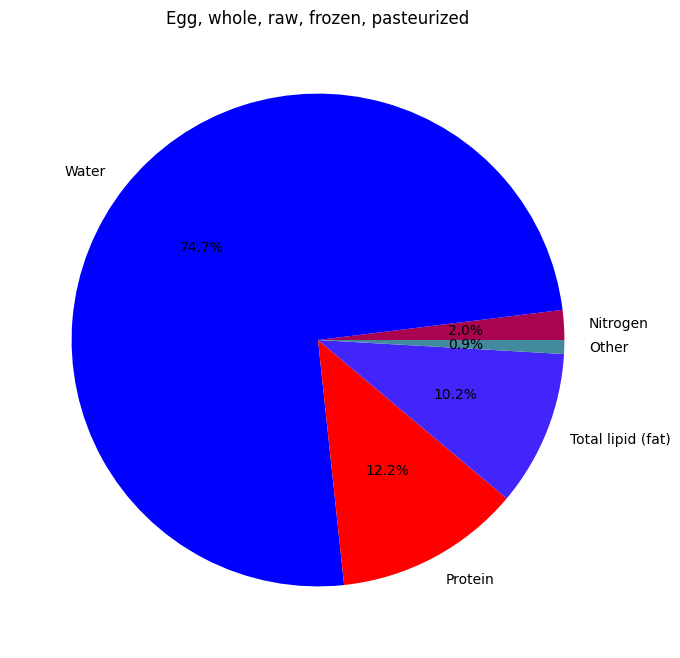

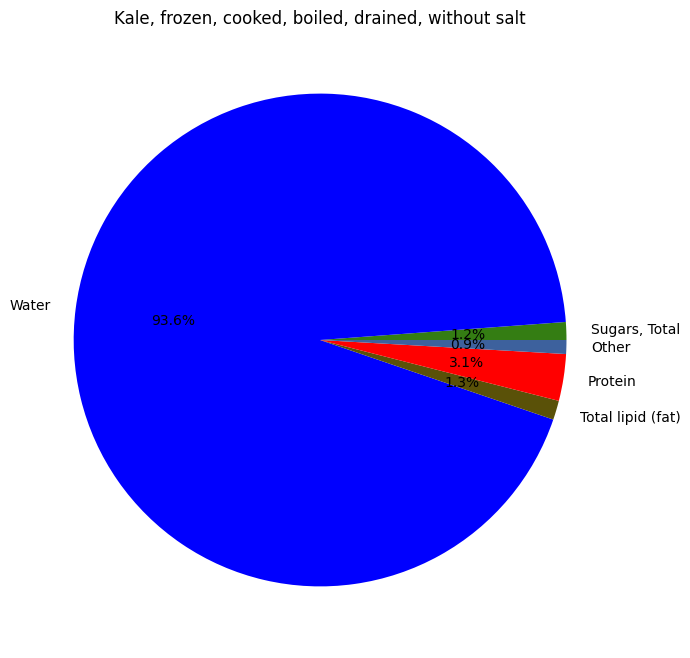

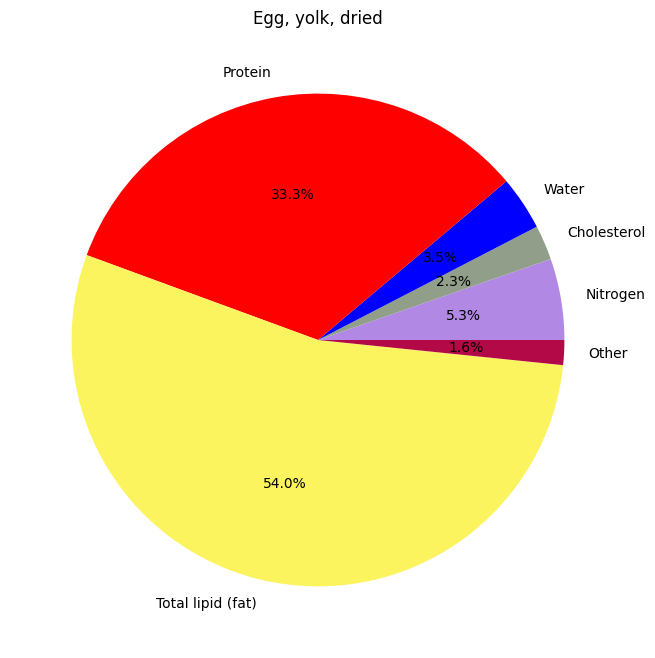

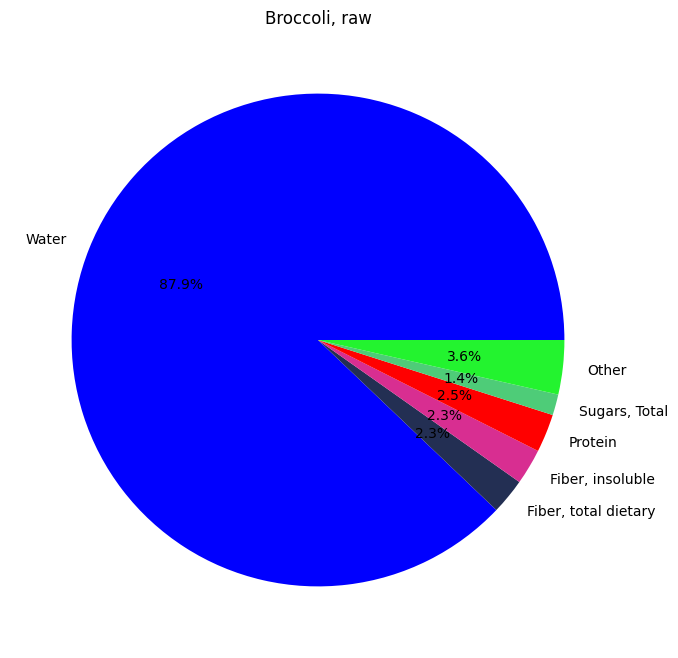

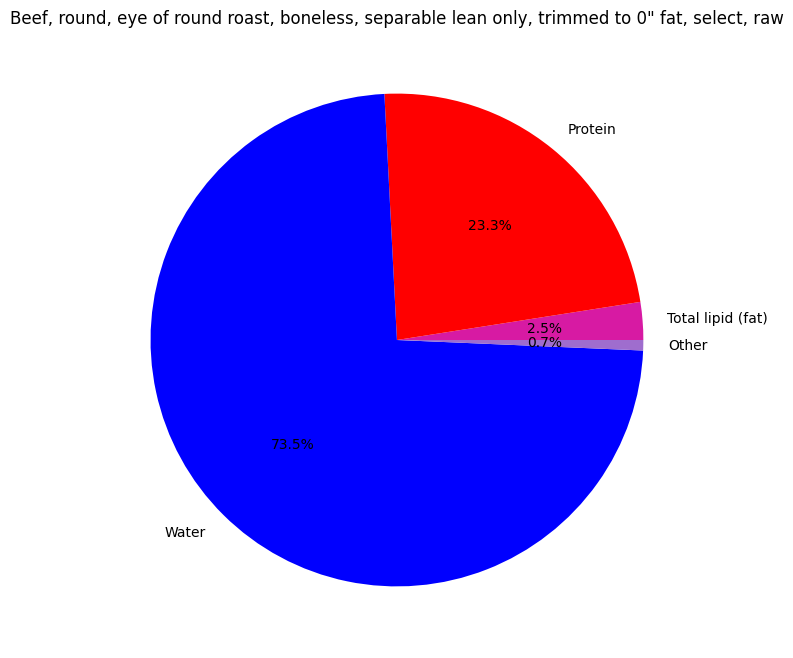

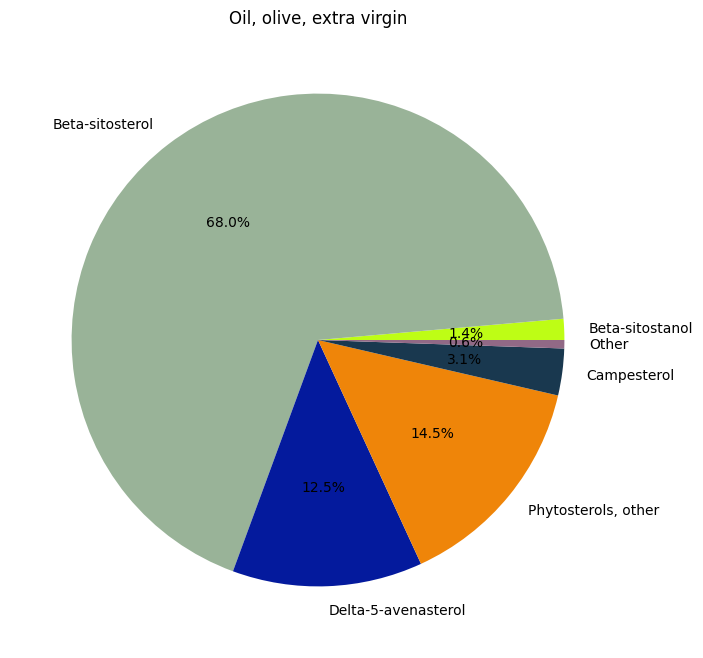

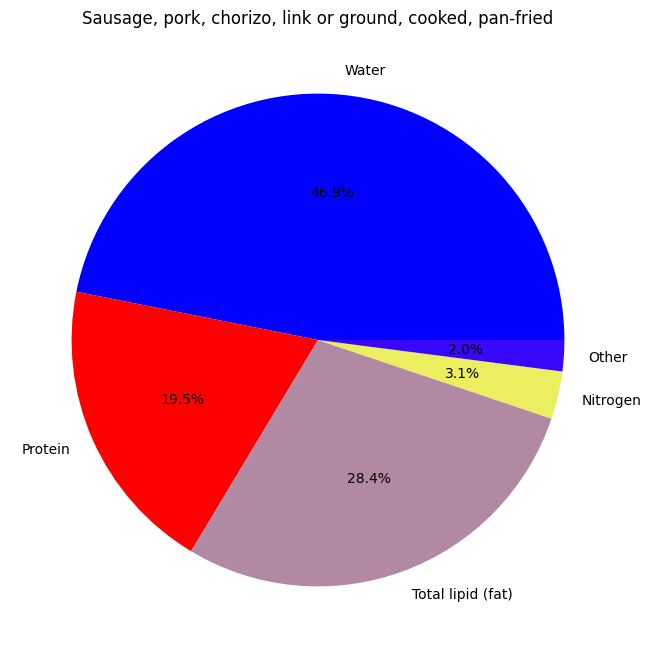

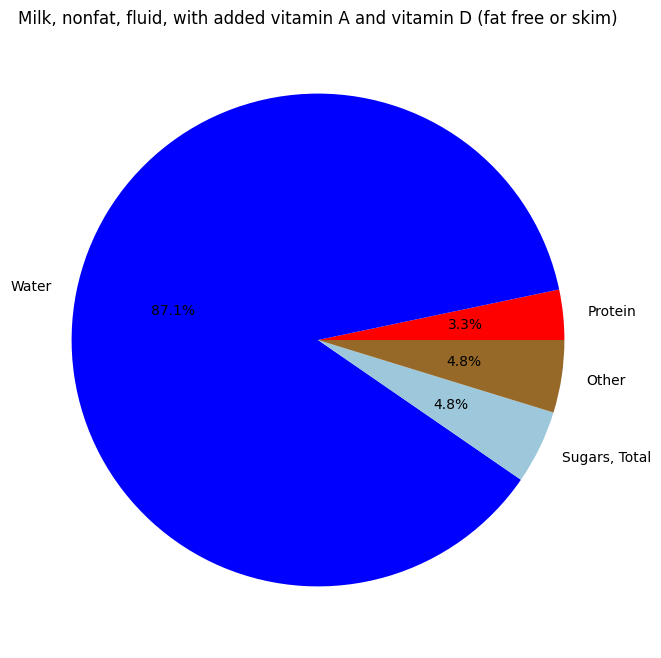

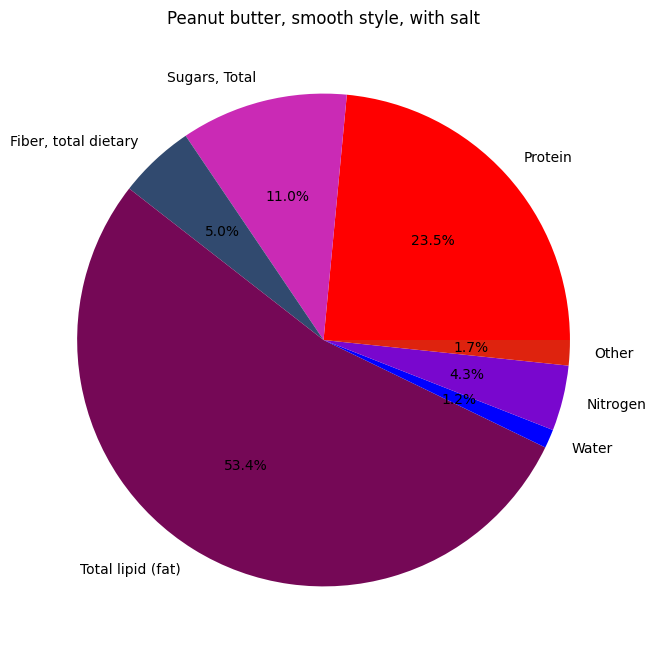

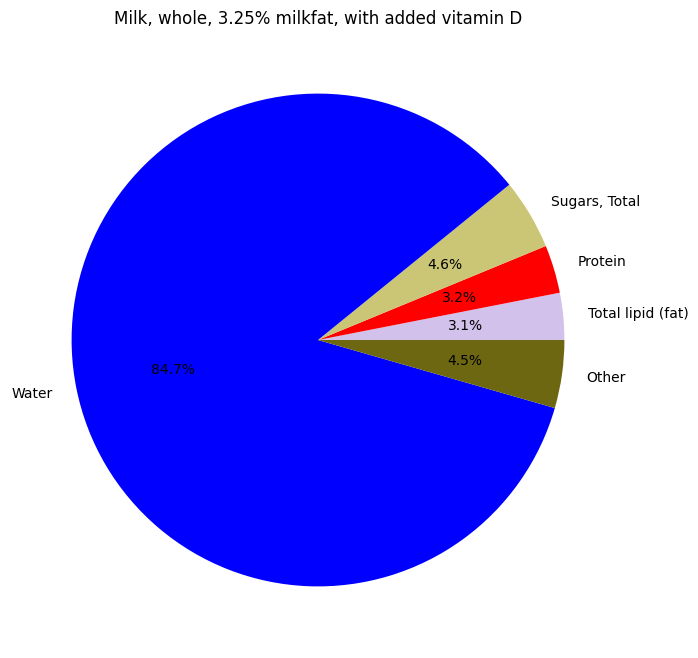

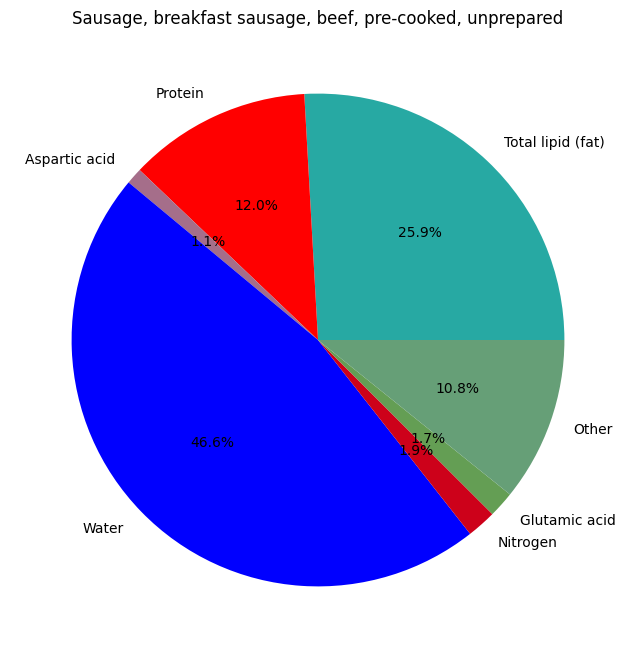

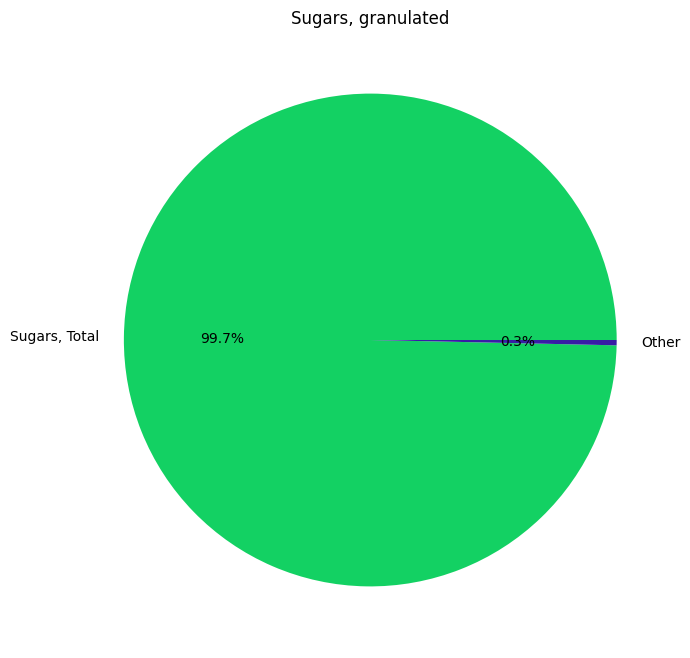

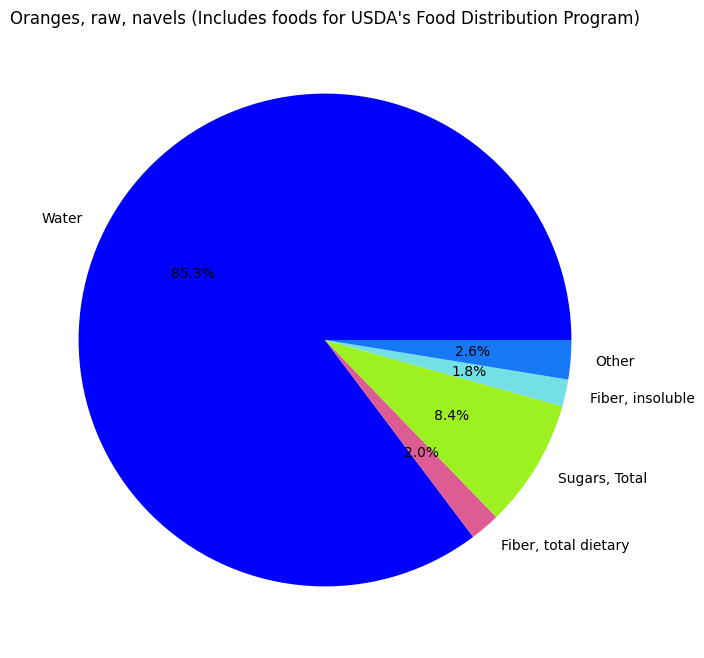

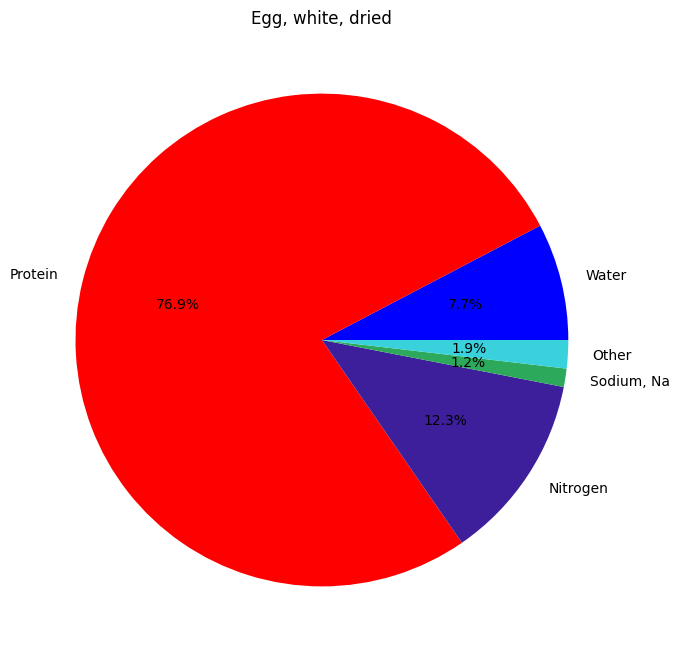

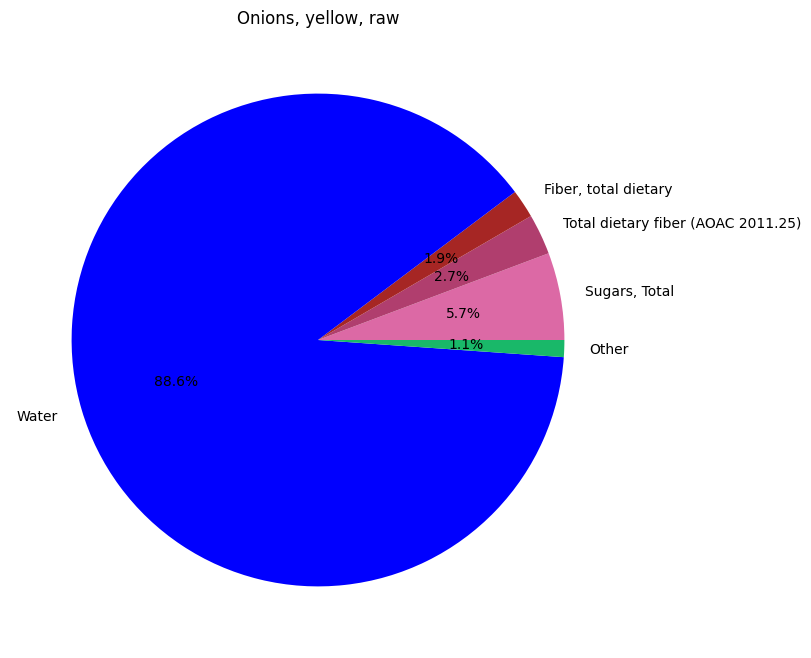

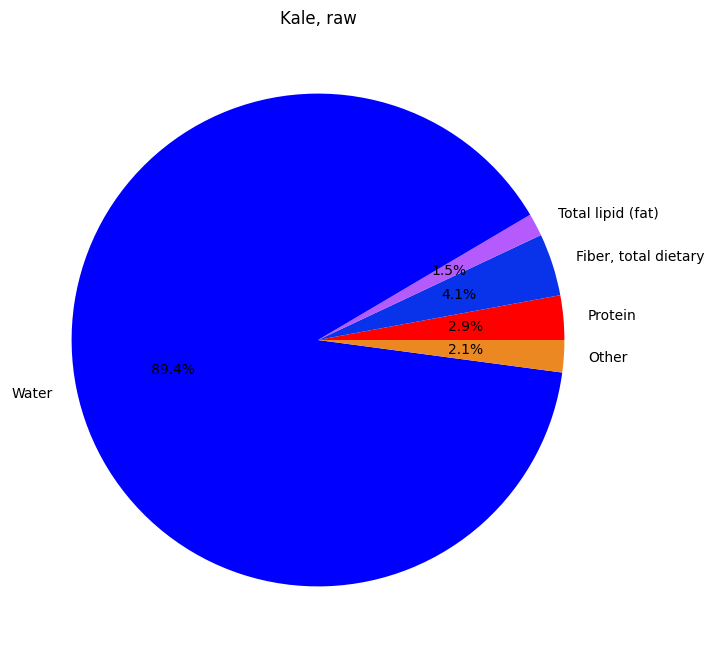

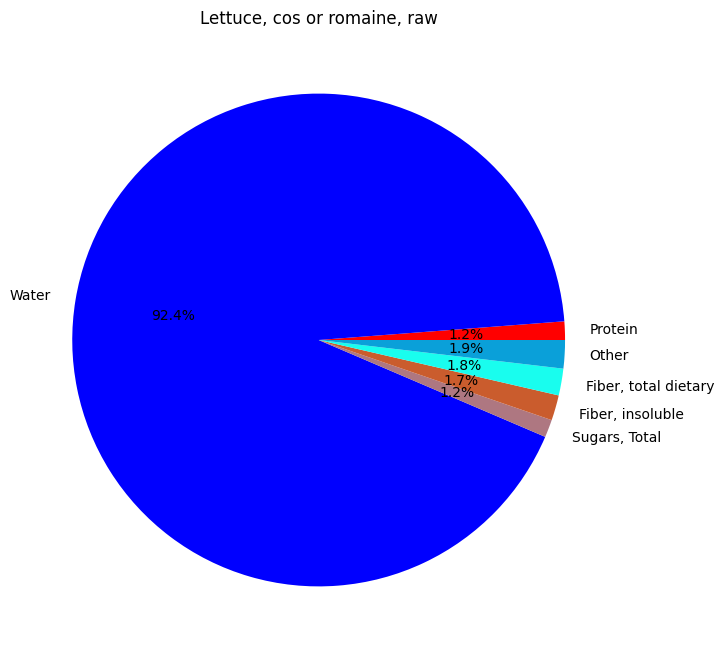

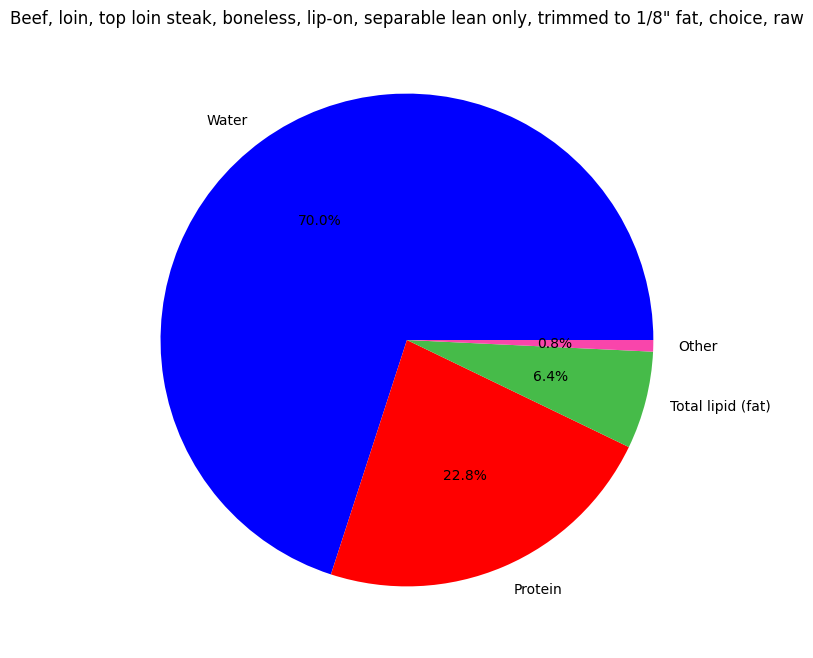

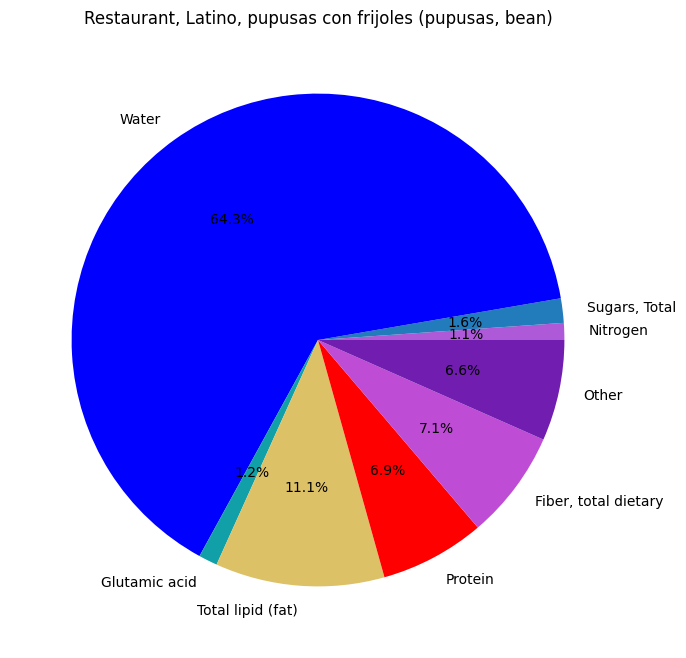

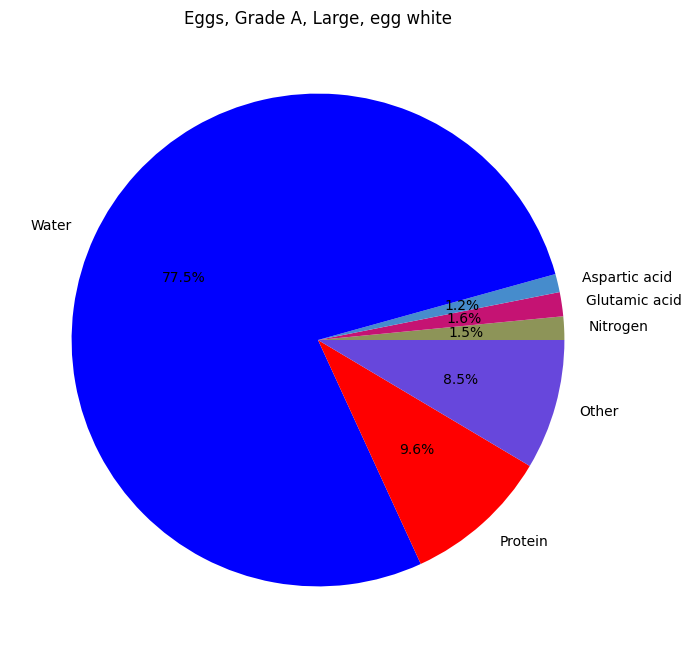

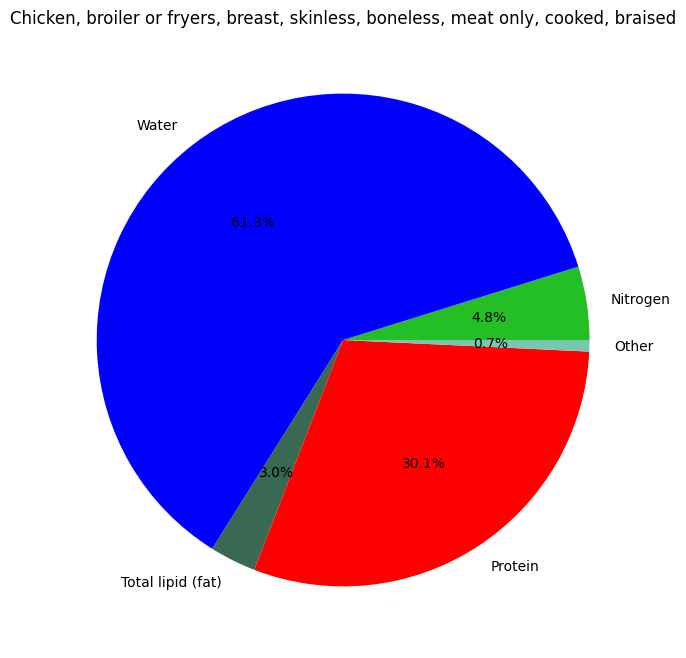

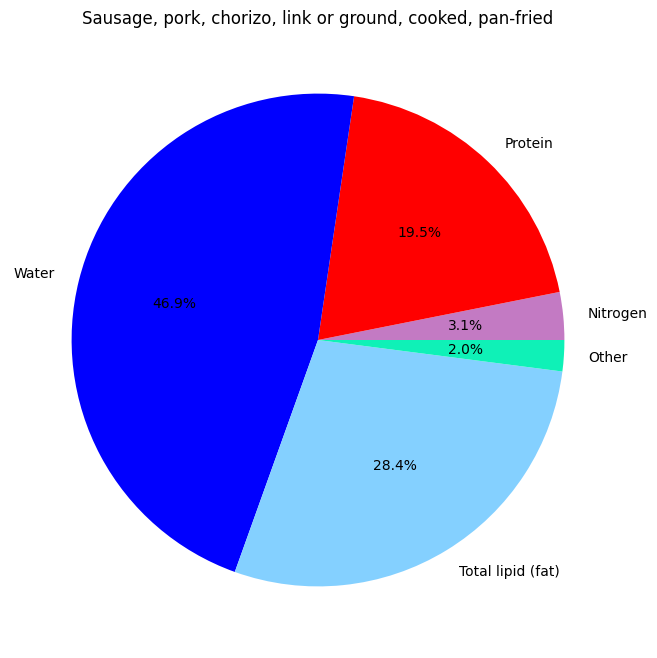

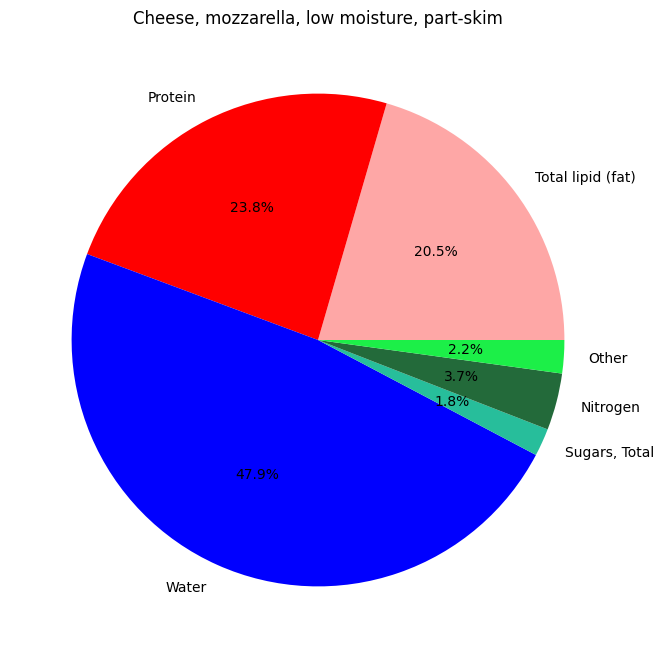

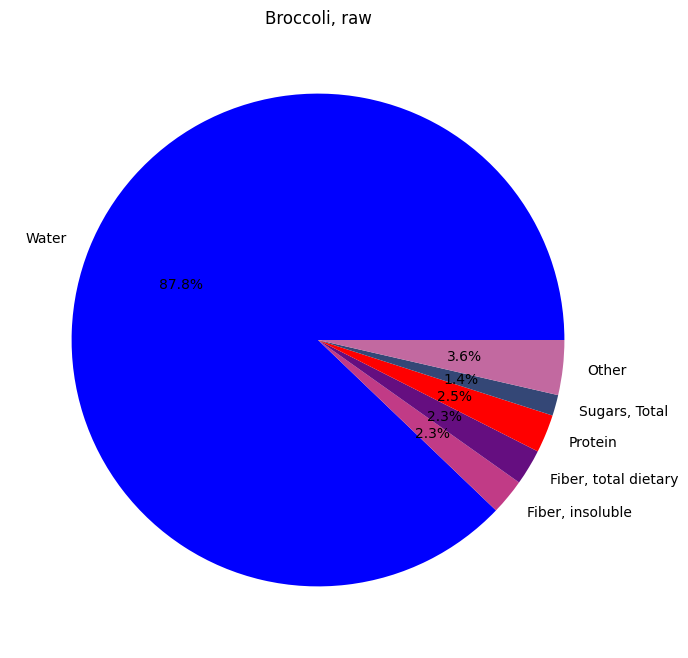

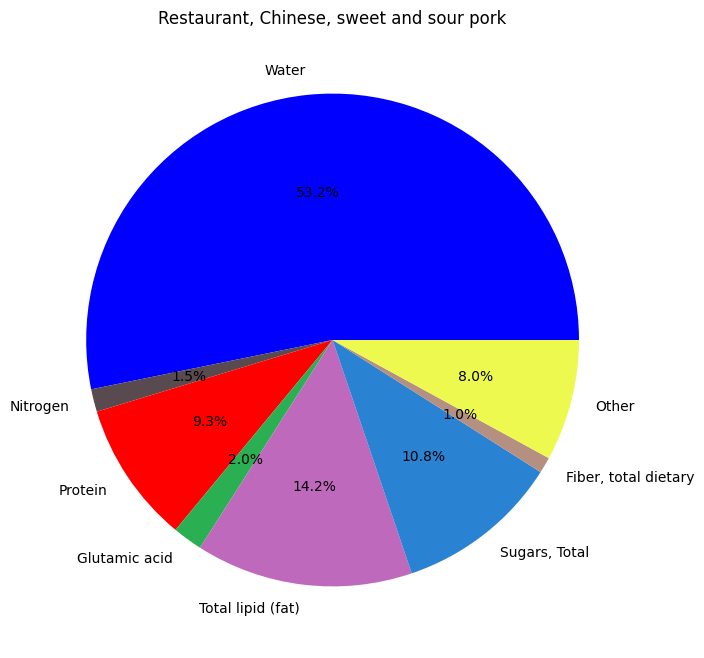

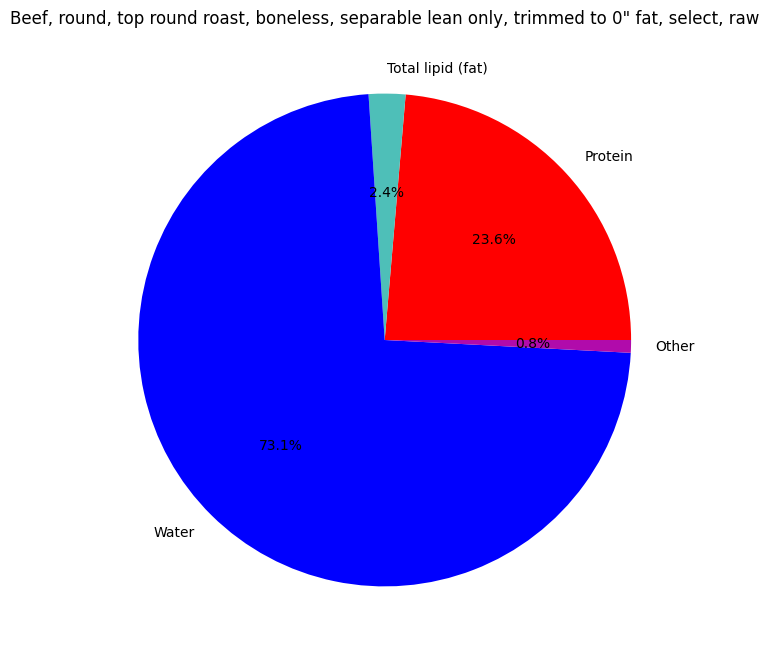

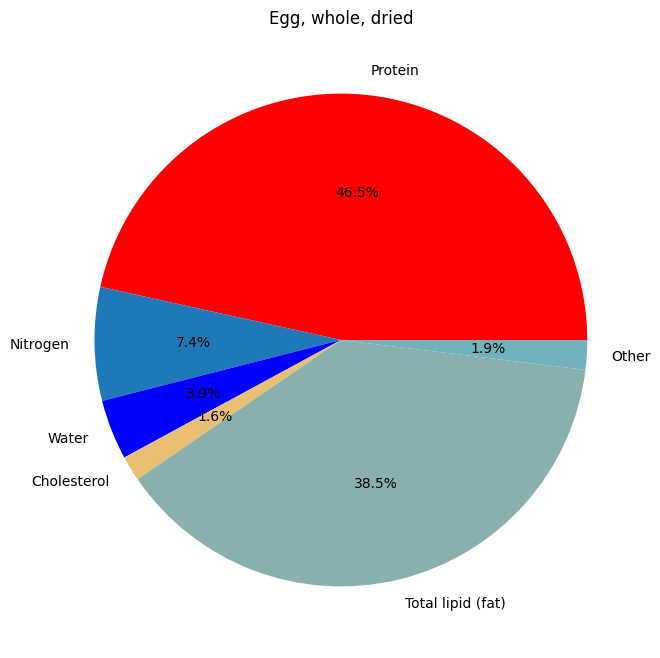

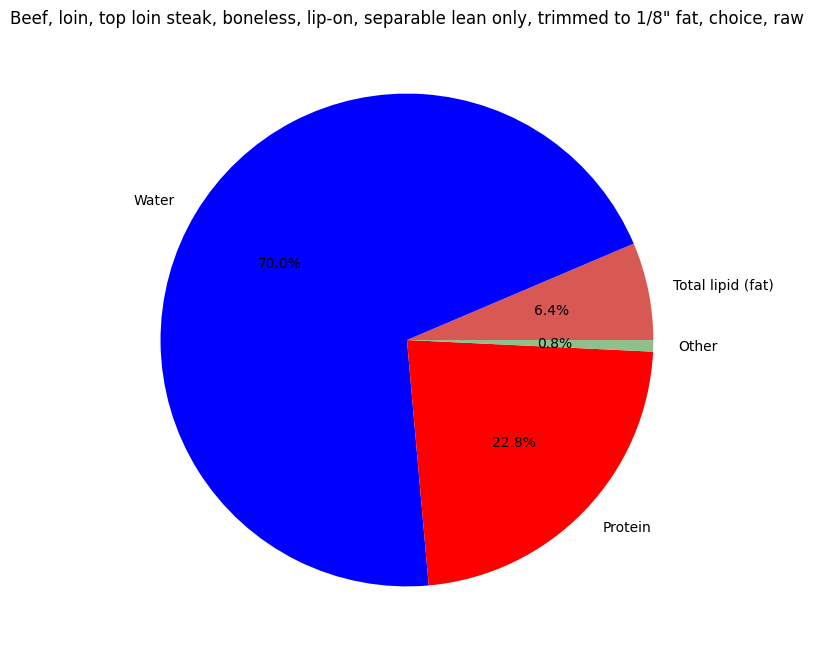

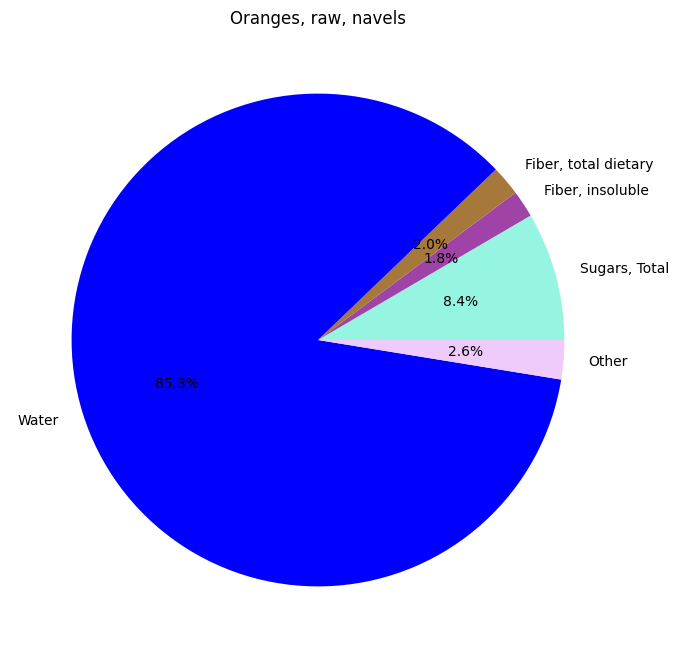

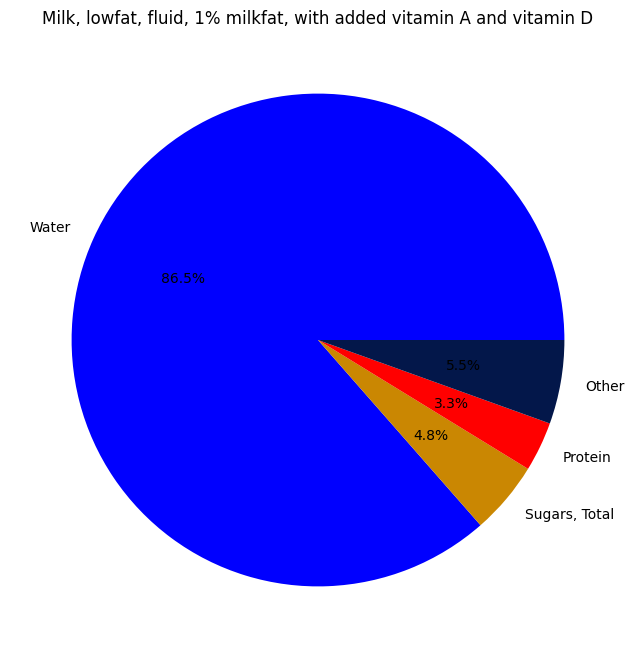

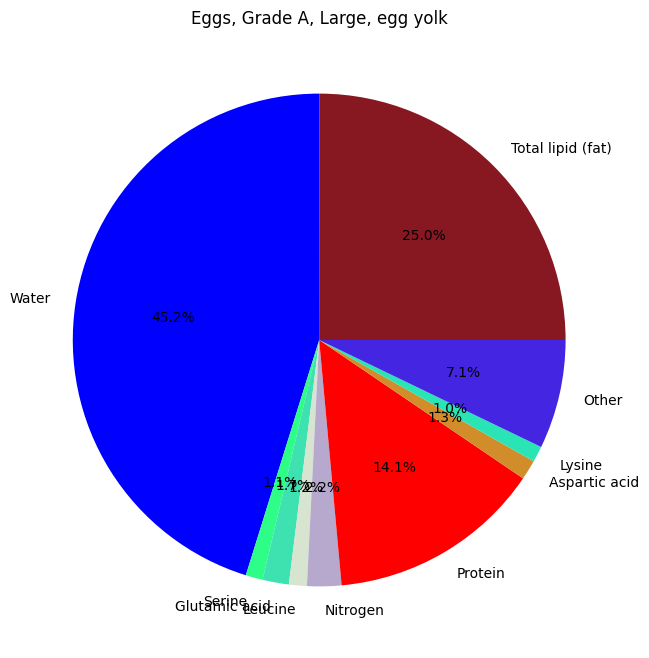

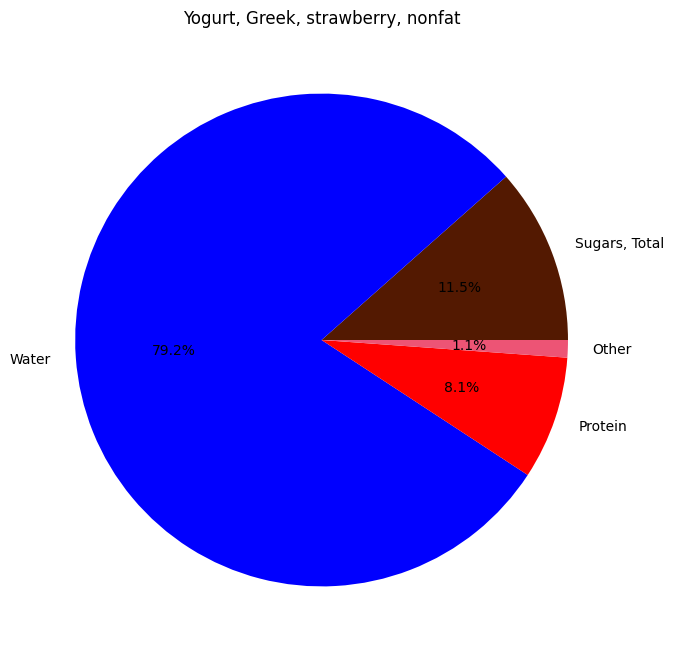

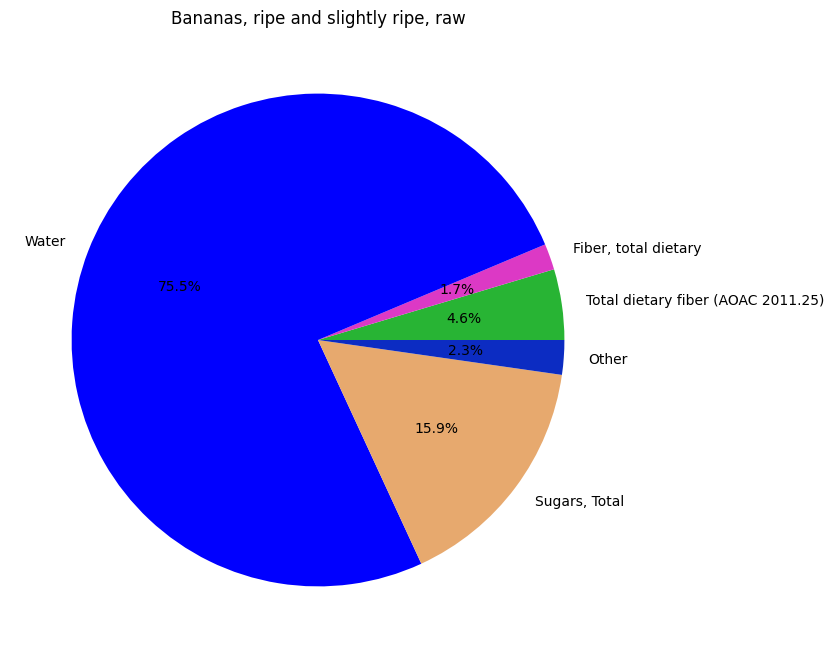

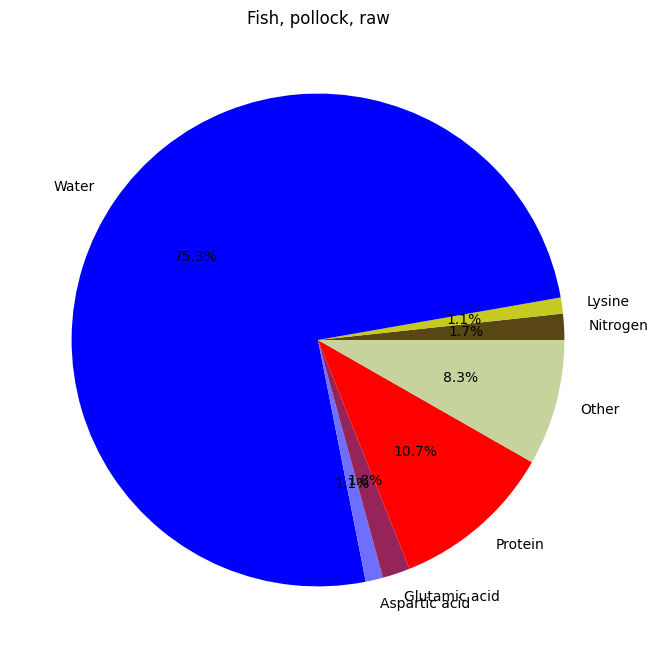

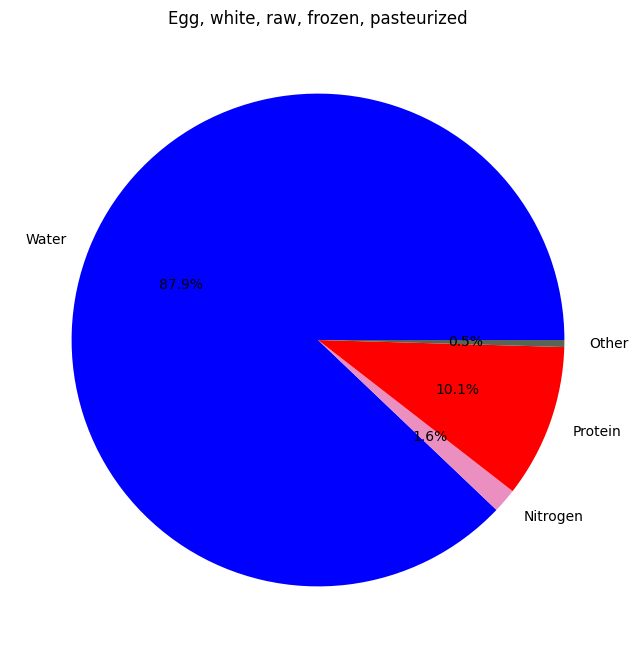

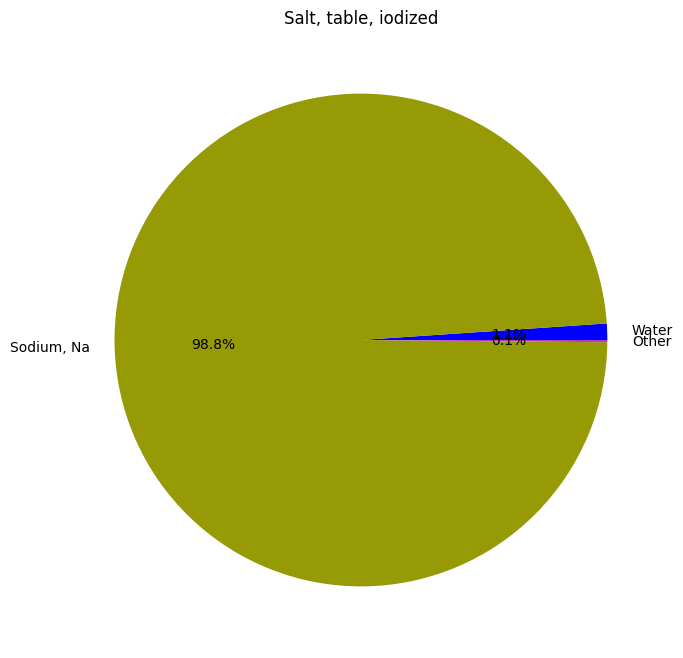

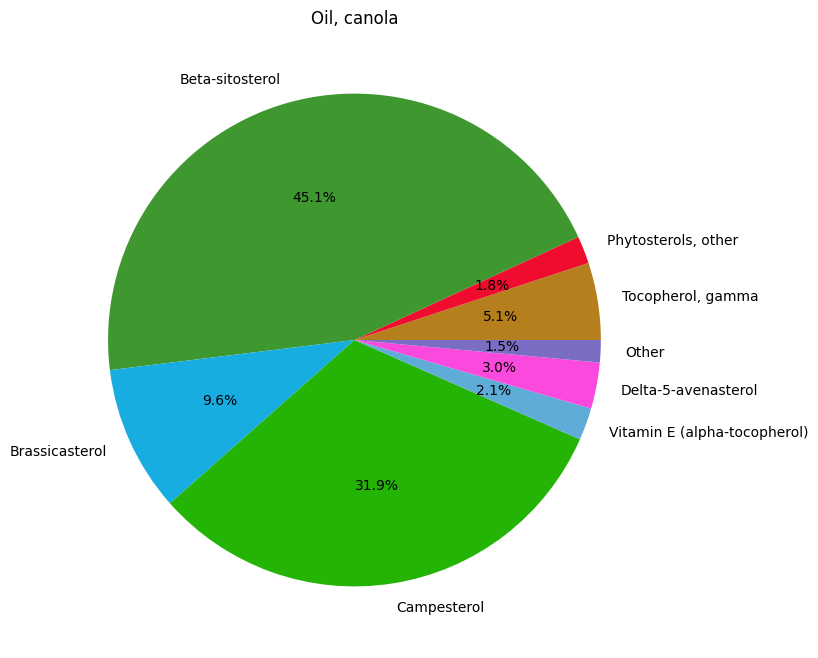

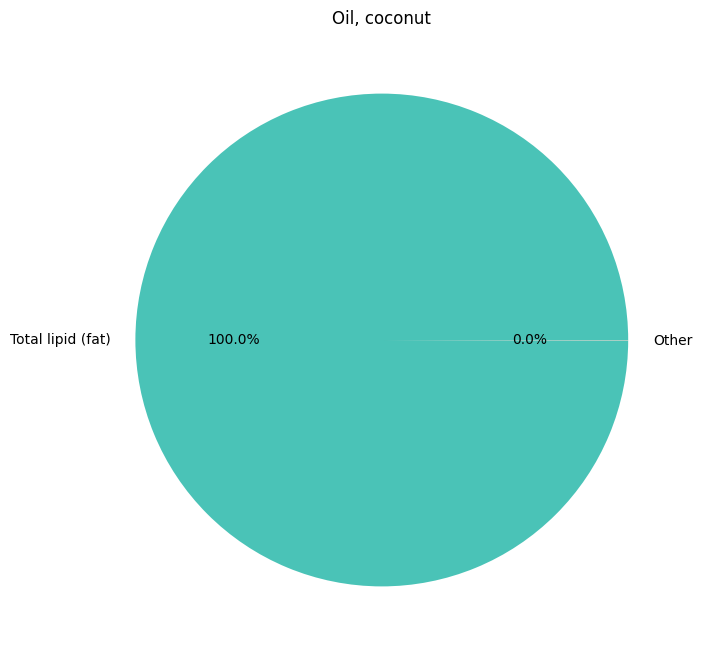

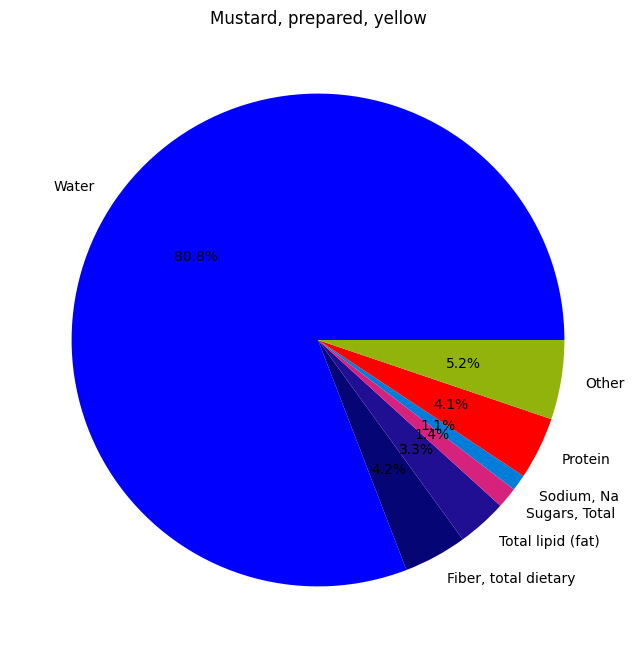

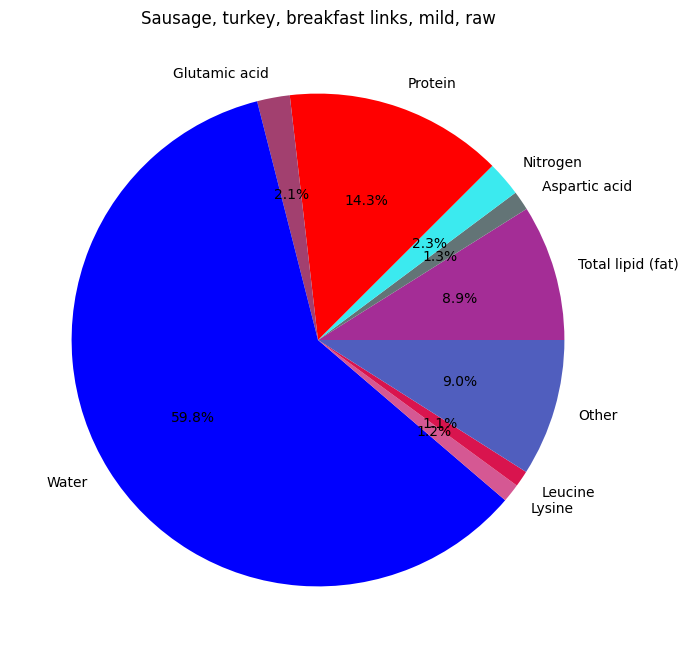

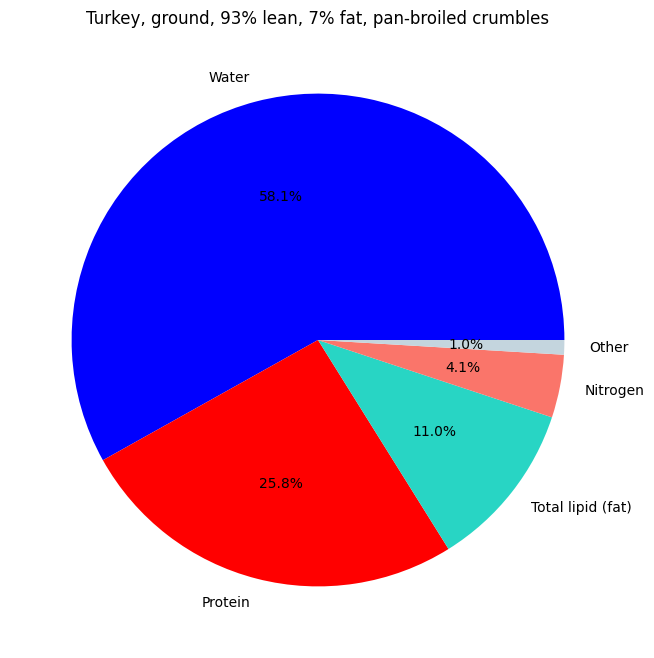

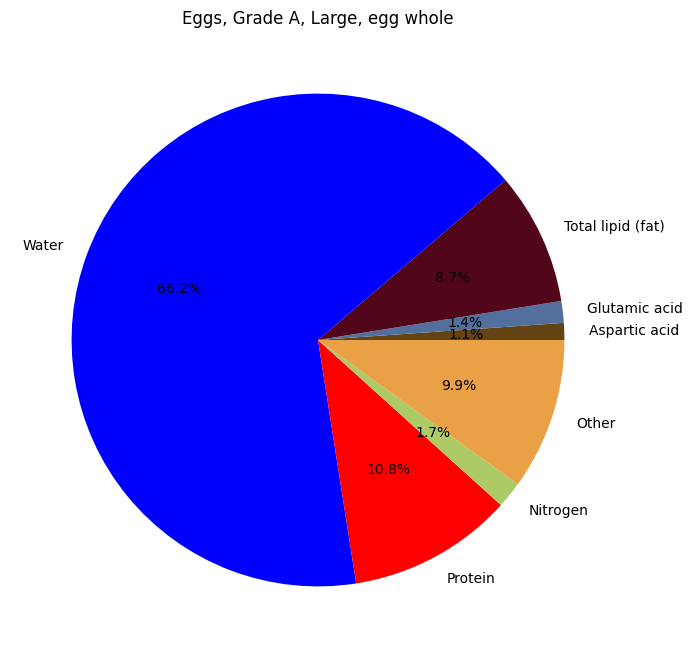

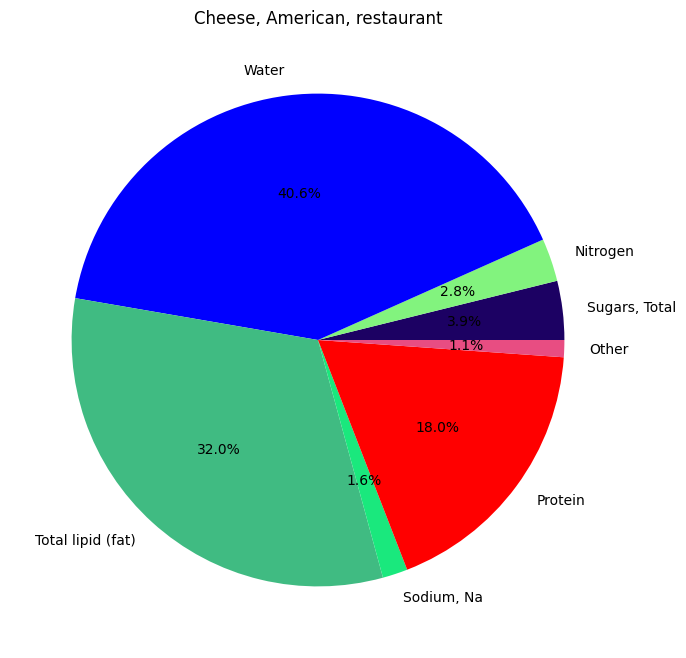

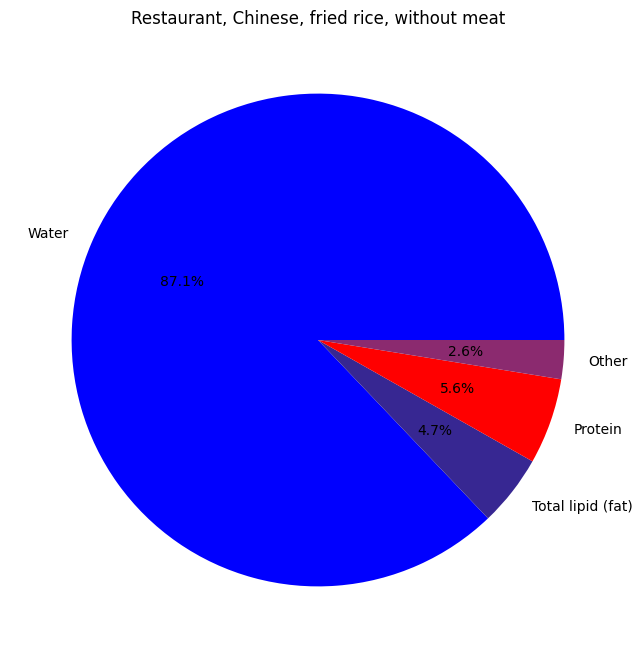

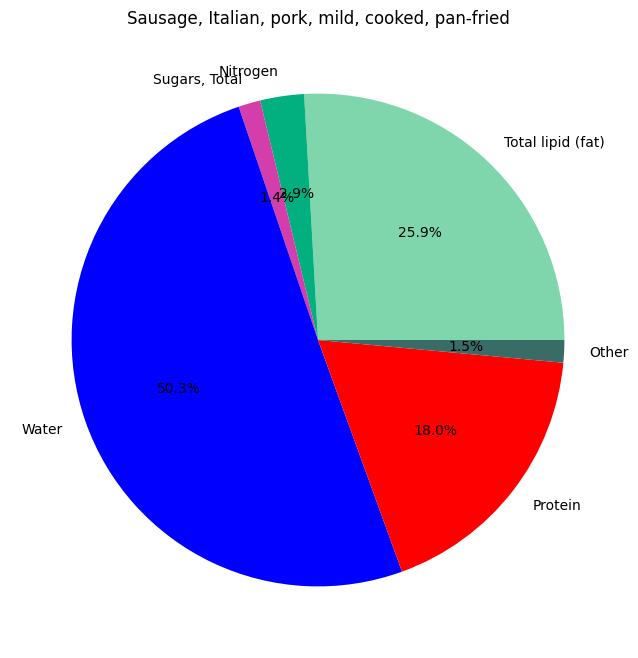

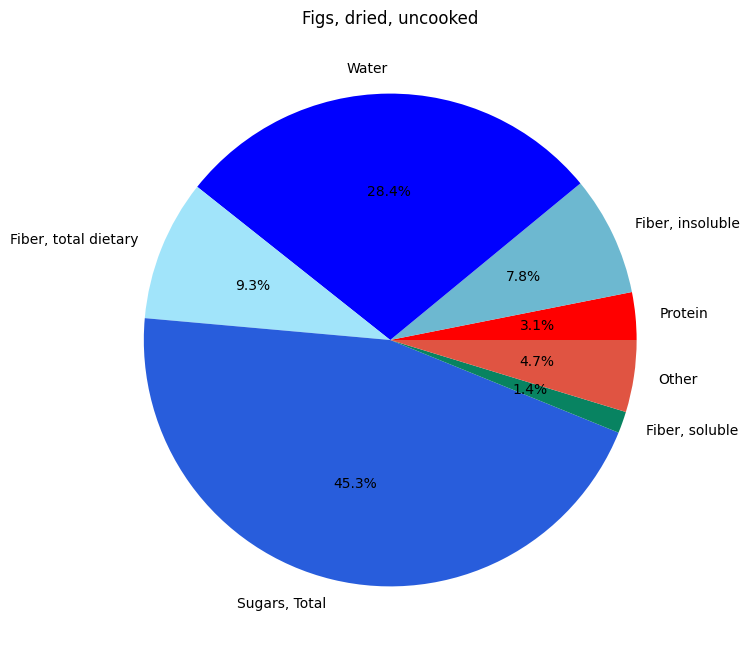

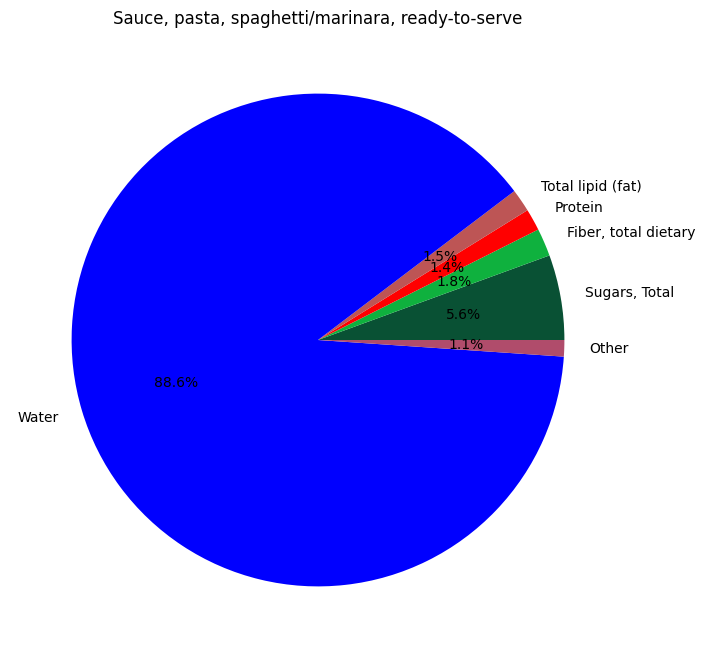

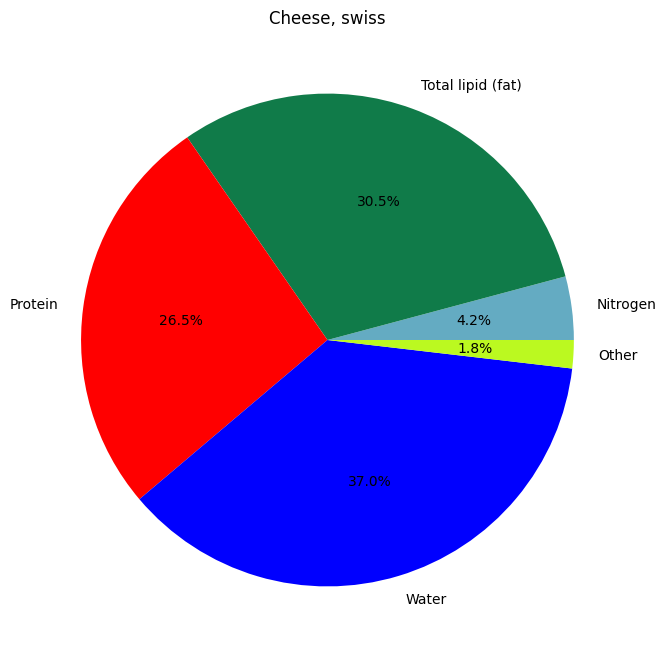

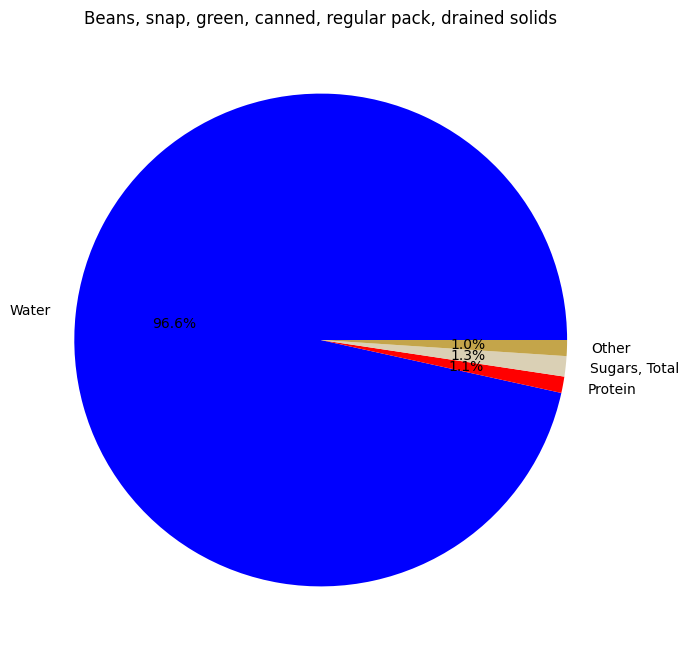

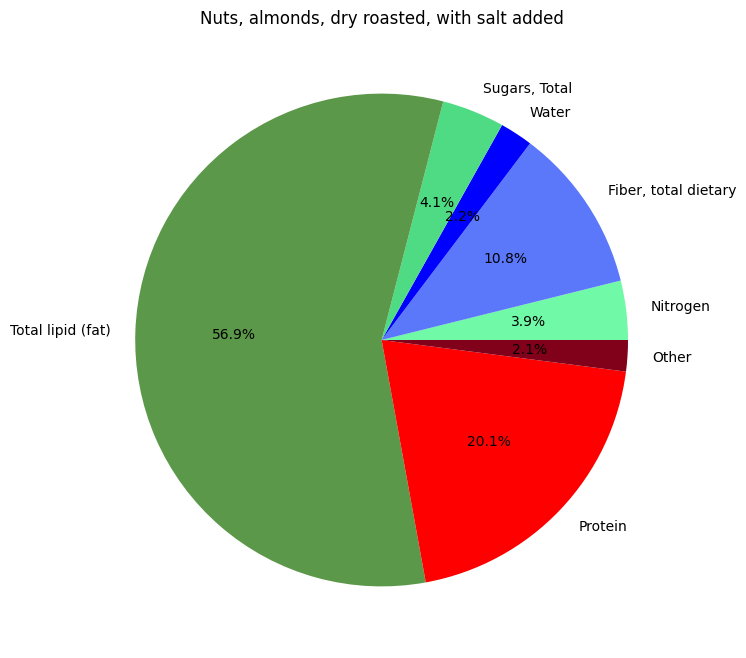

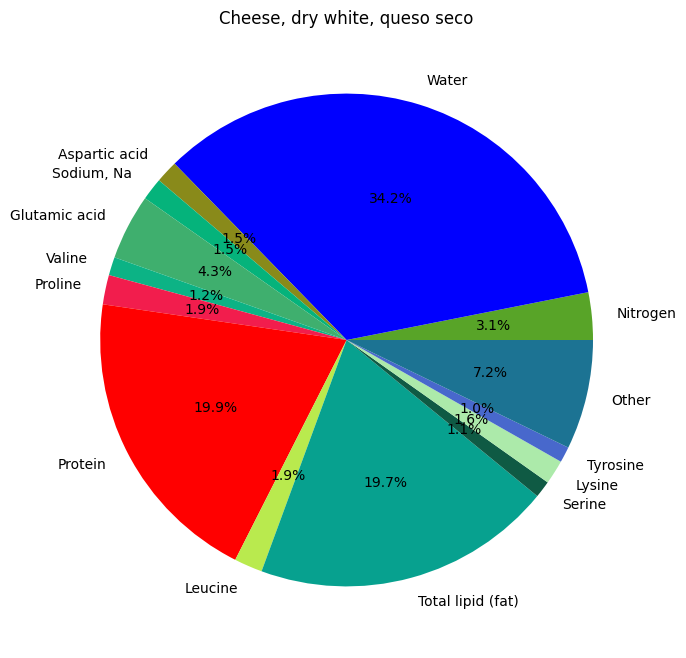

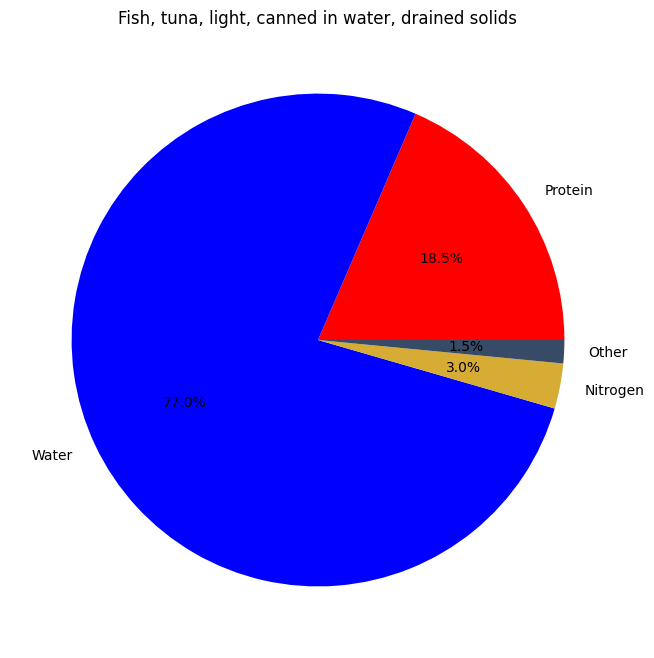

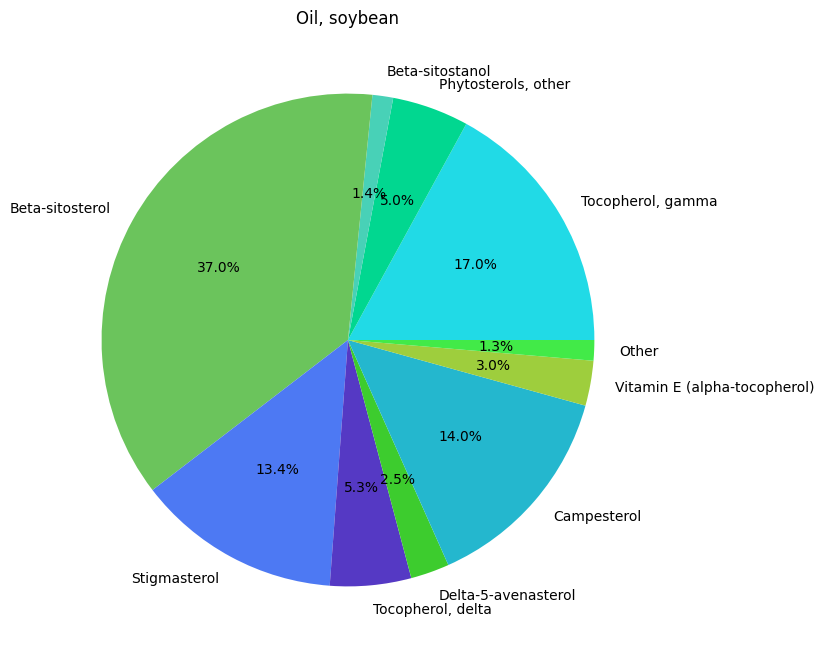

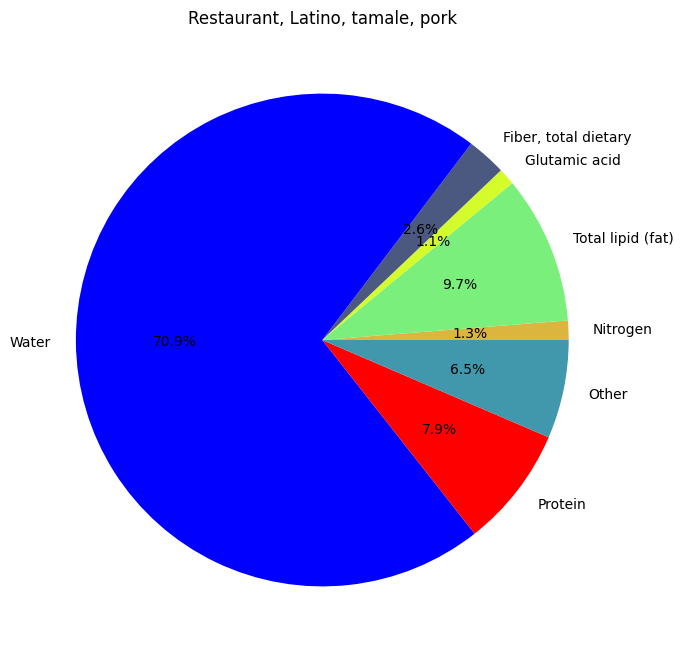

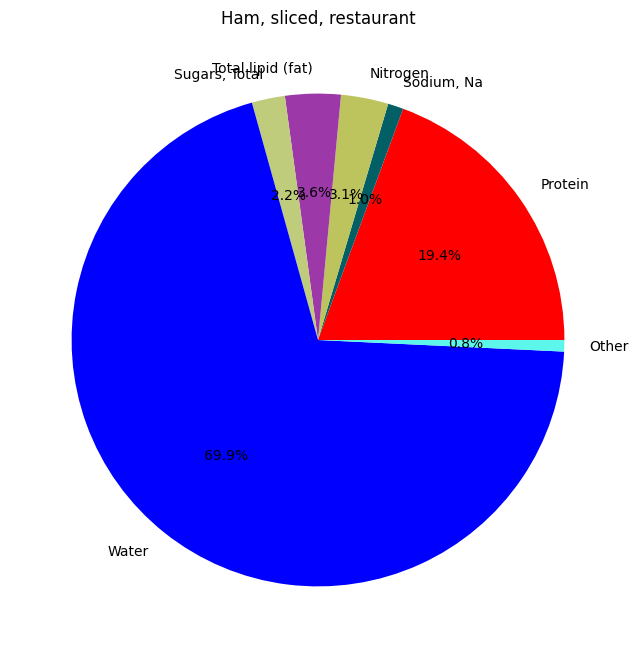

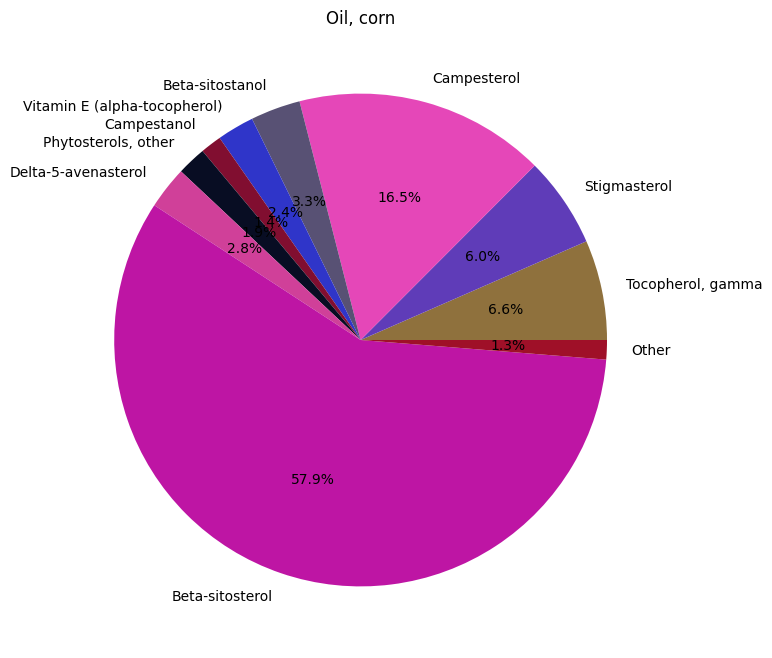

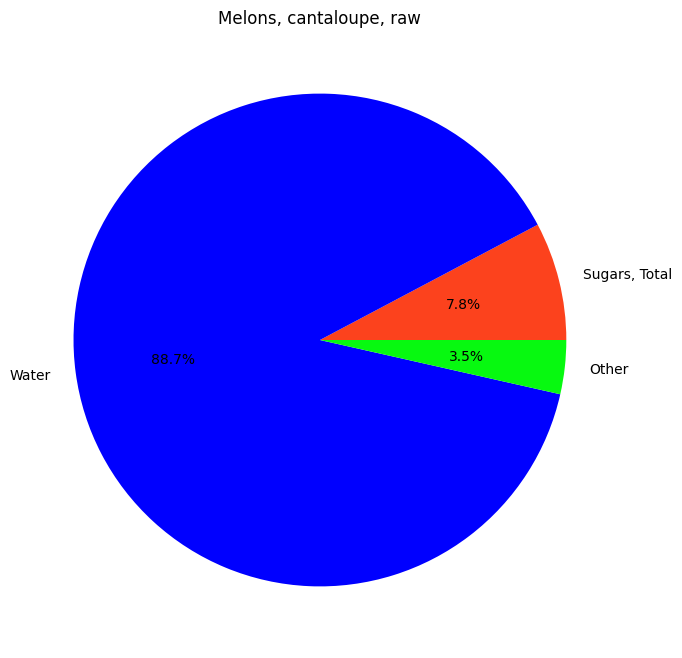

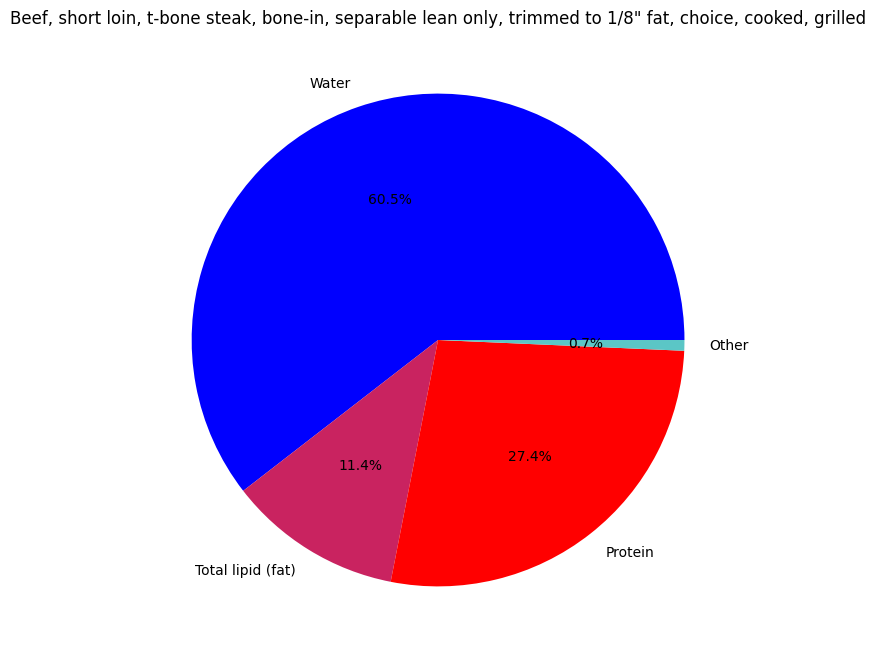

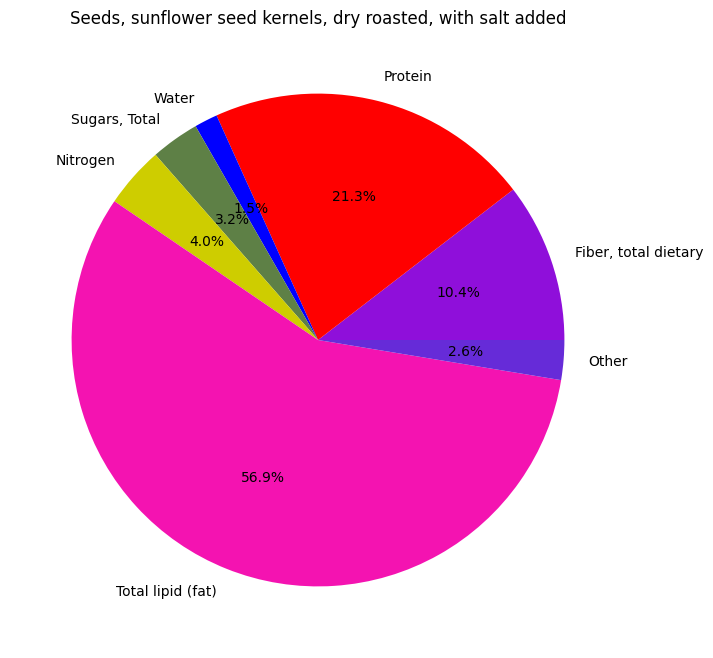

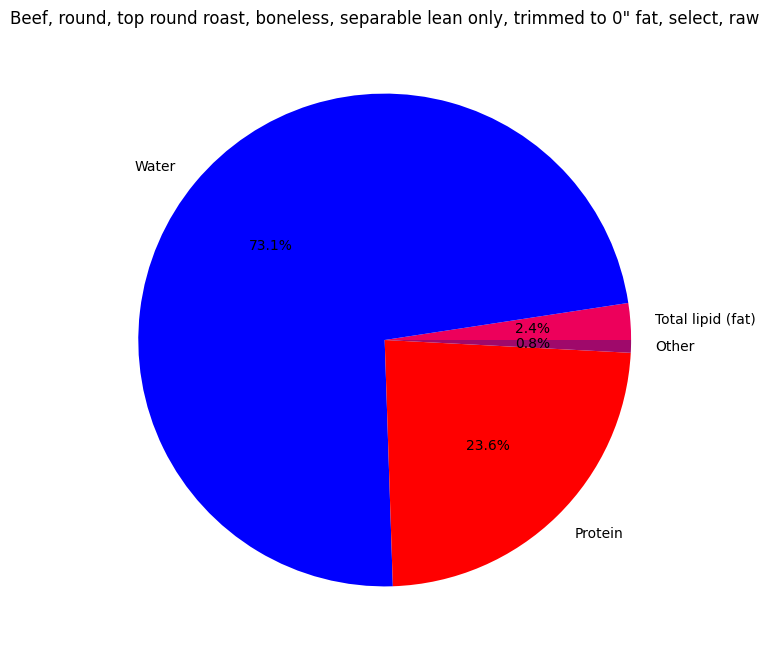

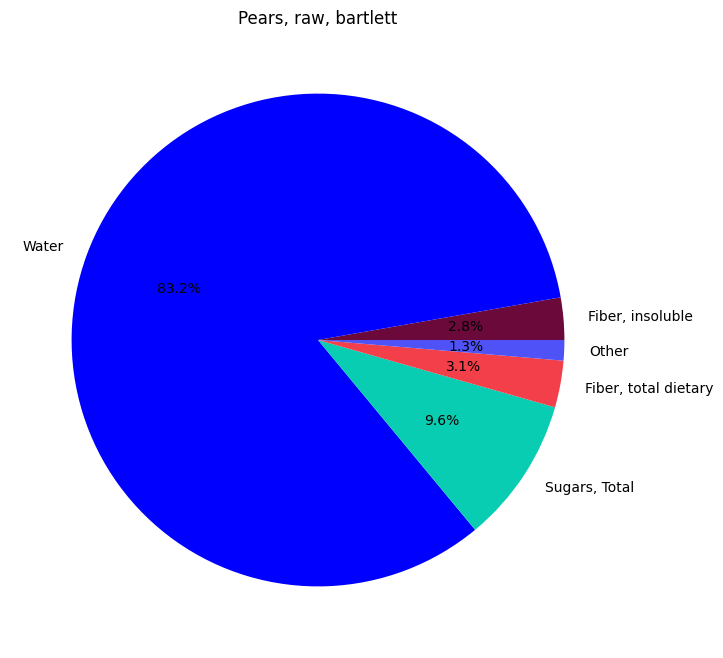

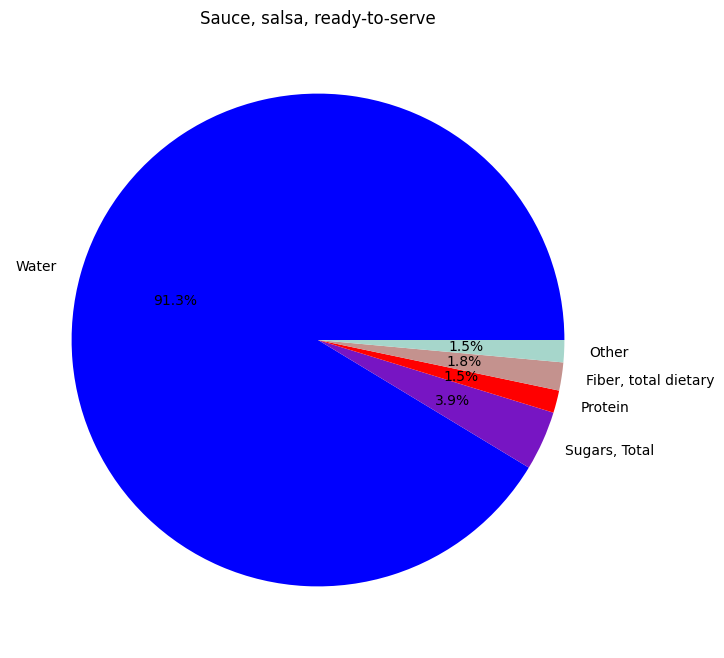

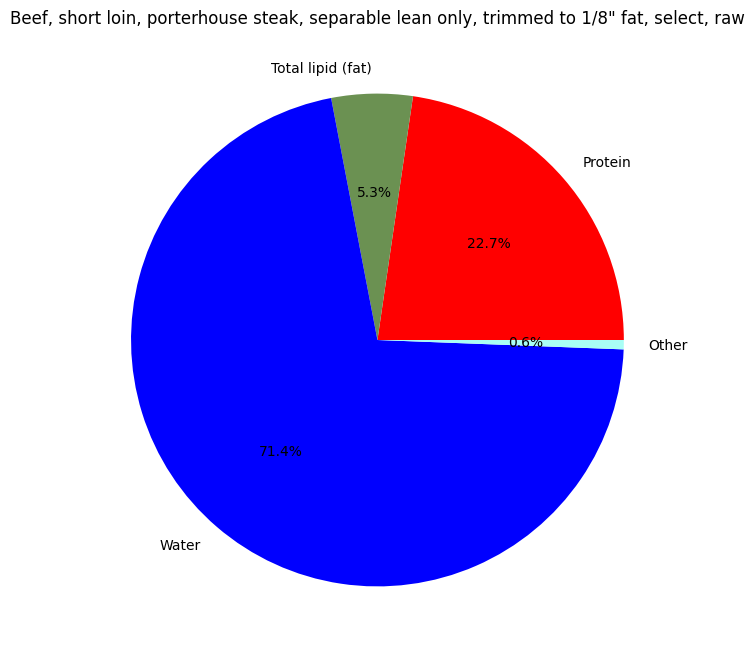

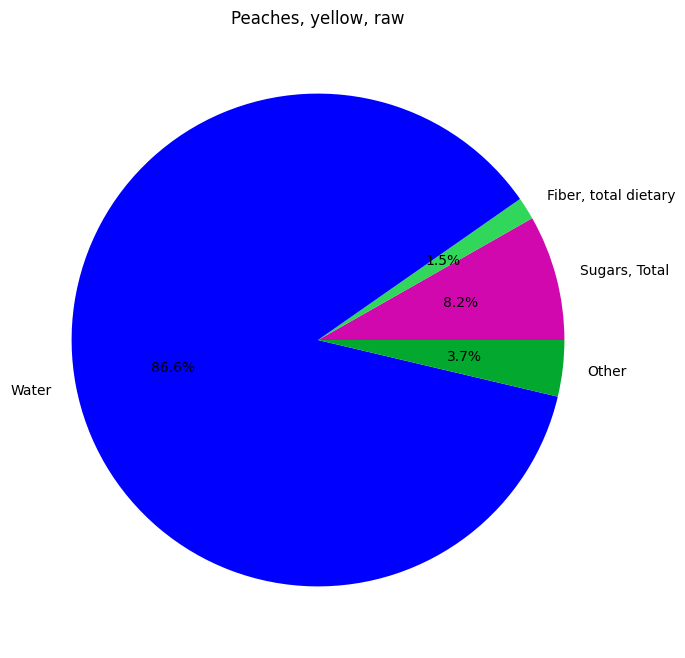

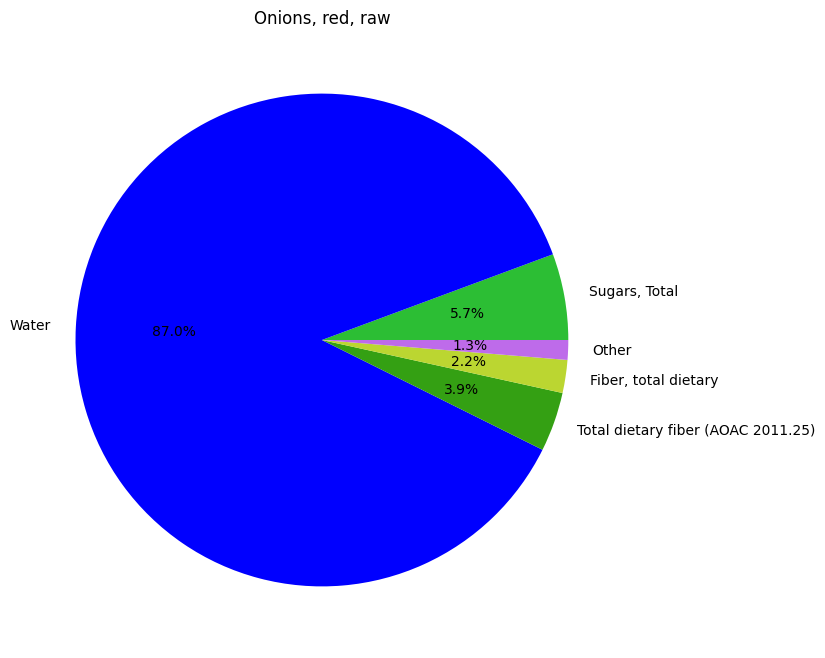

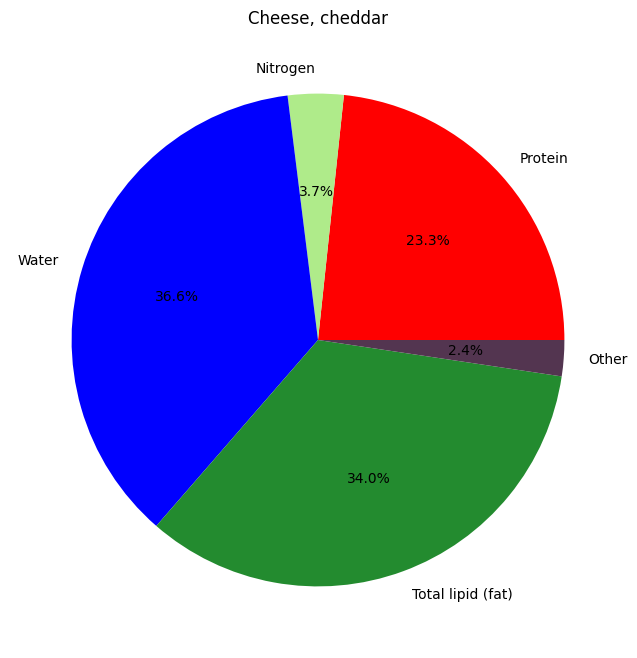

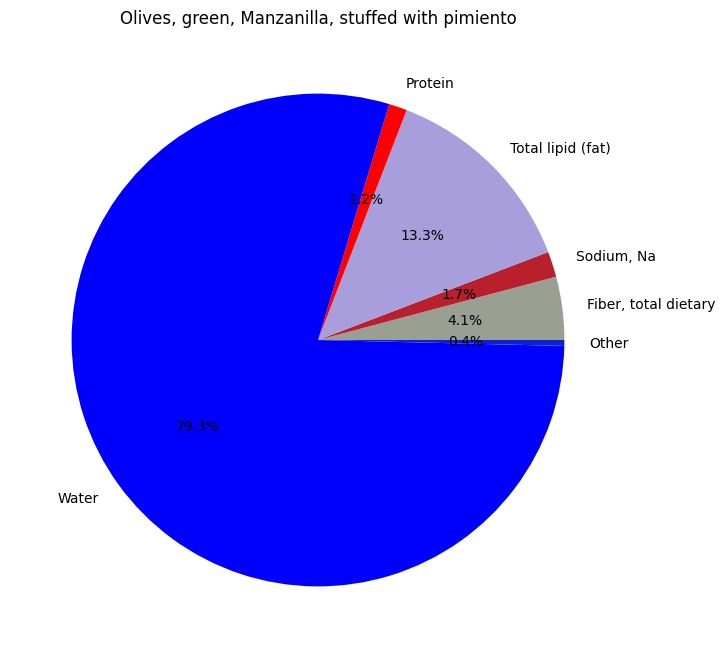

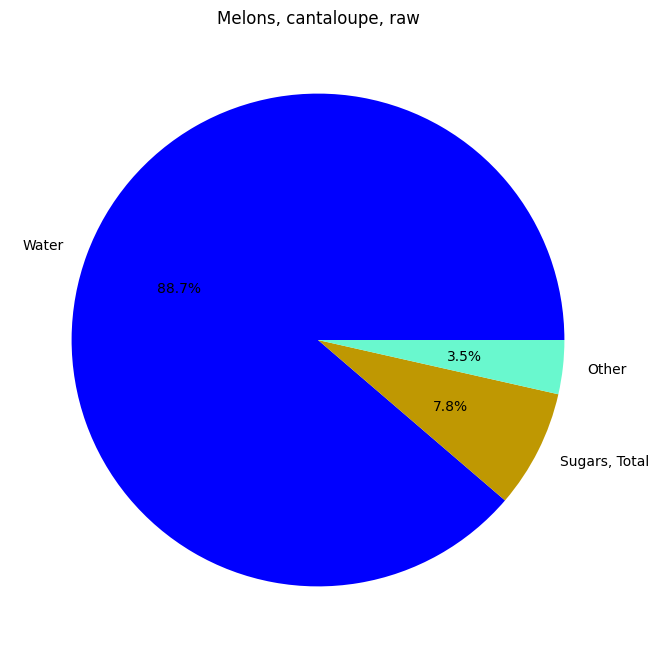

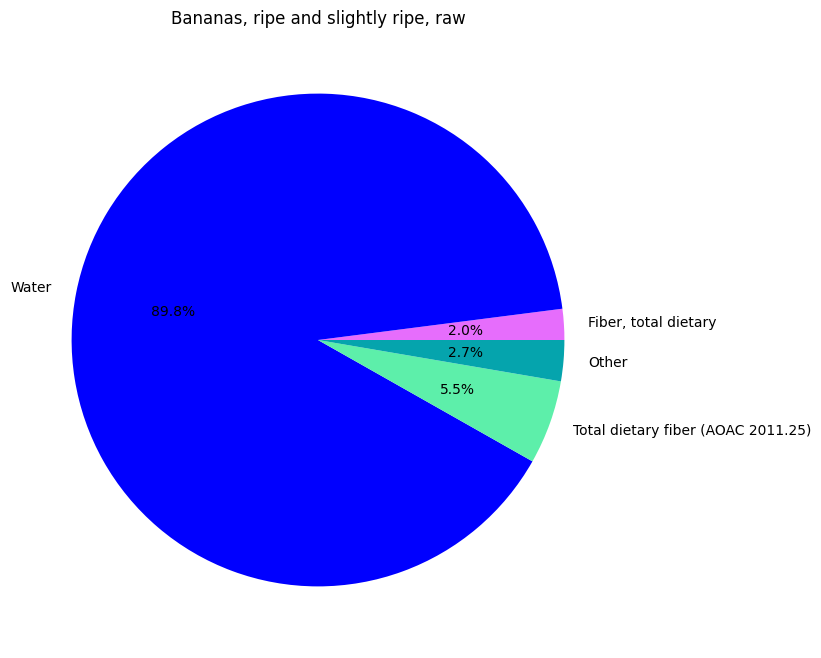

In [7]:
for doc in result:
    nutrient_names = [nutrient['name'] for nutrient in doc['nutrients']]
    nutrient_amounts = [nutrient['amountInGrams'] for nutrient in doc['nutrients']]

    total_amount = sum(nutrient_amounts)

    threshold = 0.01 * total_amount
    other_amount = sum(amount for amount in nutrient_amounts if amount < threshold)
    nutrient_names_filtered = []
    nutrient_amounts_filtered = []
    for name, amount in zip(nutrient_names, nutrient_amounts):
        if amount >= threshold:
            nutrient_names_filtered.append(name)
            nutrient_amounts_filtered.append(amount)
    if other_amount > 0:
        nutrient_names_filtered.append('Other')
        nutrient_amounts_filtered.append(other_amount)

    colors = []
    for name in nutrient_names_filtered:
        colors.append(nutrient_colors.get(name, default_color))

    colors = [color if color != default_color else '#{:06x}'.format(random.randint(0, 0xFFFFFF)) for color in colors]

    plt.figure(figsize=(8, 8))
    plt.pie(nutrient_amounts_filtered, labels=nutrient_names_filtered, autopct='%1.1f%%', colors=colors)
    plt.title(doc['description'])
    
    cleaned_description = clean_description(doc['description'])
    
    plt.savefig(f"{cleaned_description}.png")
    plt.show()

In [8]:
import pandas as pd
import seaborn as sns

In [9]:
pipeline = [
    {
        '$match': {
            'nutrients.name': 'Protein'
        }
    }, {
        '$project': {
            '_id': 0, 
            'description': 1, 
            'proteinAmount': {
                '$arrayElemAt': [
                    {
                        '$filter': {
                            'input': '$nutrients', 
                            'as': 'nutrient', 
                            'cond': {
                                '$eq': [
                                    '$$nutrient.name', 'Protein'
                                ]
                            }
                        }
                    }, 0
                ]
            }
        }
    }, {
        '$project': {
            '_id': 0, 
            'description': 1, 
            'proteinAmount': '$proteinAmount.amount'
        }
    }, {
        '$sort': {
            'proteinAmount': -1
        }
    }, {
        '$limit': 10
    }
]

In [10]:
result = collection.aggregate(pipeline)
top_protein_foods_df = pd.DataFrame(result)
top_protein_foods_df['truncated_description'] = top_protein_foods_df['description'].apply(lambda x: x[:20] + '...' if len(x) > 20 else x)
top_protein_foods_df

description  proteinAmount   
0                                  Egg, white, dried           79.9  \
1                                  Egg, whole, dried           48.1   
2             Pork, cured, bacon, cooked, restaurant           40.9   
3                                   Egg, yolk, dried           34.2   
4  Chicken, broiler or fryers, breast, skinless, ...           32.1   
5                           Cheese, parmesan, grated           29.6   
6  Beef, loin, tenderloin roast, separable lean o...           27.7   
7  Beef, loin, tenderloin roast, separable lean o...           27.7   
8  Beef, short loin, t-bone steak, bone-in, separ...           27.3   
9  Beef, short loin, t-bone steak, bone-in, separ...           27.3   

     truncated_description  
0        Egg, white, dried  
1        Egg, whole, dried  
2  Pork, cured, bacon, ...  
3         Egg, yolk, dried  
4  Chicken, broiler or ...  
5  Cheese, parmesan, gr...  
6  Beef, loin, tenderlo...  
7  Beef, loin, tenderlo...  
8  Beef, short loin, t-...  
9  Beef, short loin, t-...

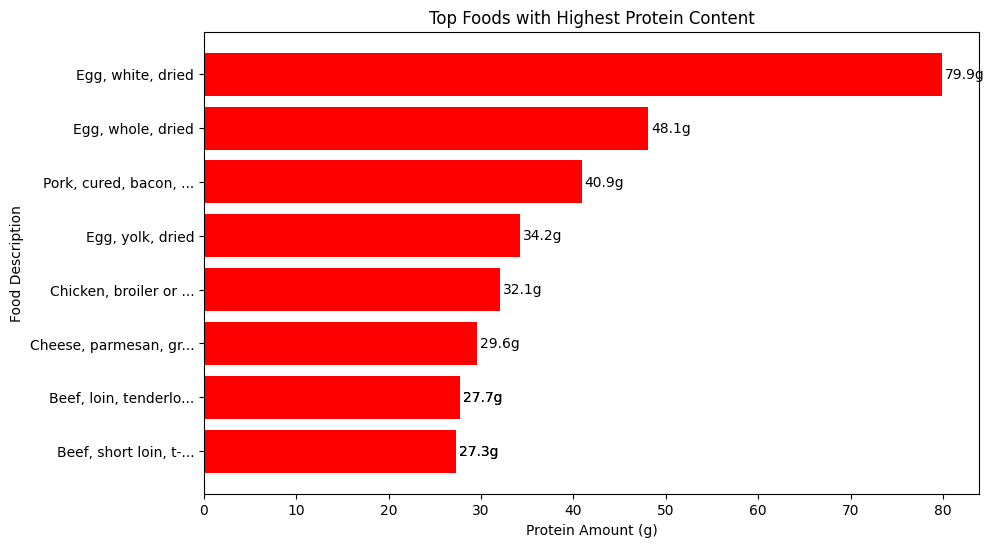

In [11]:
plt.figure(figsize=(10, 6))

bars = plt.barh(top_protein_foods_df['truncated_description'], top_protein_foods_df['proteinAmount'], color='red')

for bar, protein in zip(bars, top_protein_foods_df['proteinAmount']):
    plt.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height() / 2, f'{protein:.1f}g', va='center')

plt.xlabel('Protein Amount (g)')
plt.ylabel('Food Description')
plt.title('Top Foods with Highest Protein Content')
plt.gca().invert_yaxis()

plt.show()

In [12]:
pipeline = [
    {
        '$match': {
            '$and': [
                {
                    'nutrients.name': 'Protein'
                }, {
                    'nutrients.name': 'Cholesterol'
                }
            ]
        }
    }, {
        '$project': {
            '_id': 0, 
            'description': 1, 
            'proteinAmount': {
                '$arrayElemAt': [
                    {
                        '$filter': {
                            'input': '$nutrients', 
                            'as': 'nutrient', 
                            'cond': {
                                '$eq': [
                                    '$$nutrient.name', 'Protein'
                                ]
                            }
                        }
                    }, 0
                ]
            }, 
            'cholesterolAmount': {
                '$arrayElemAt': [
                    {
                        '$filter': {
                            'input': '$nutrients', 
                            'as': 'nutrient', 
                            'cond': {
                                '$eq': [
                                    '$$nutrient.name', 'Cholesterol'
                                ]
                            }
                        }
                    }, 0
                ]
            }
        }
    }, {
        '$project': {
            'description': 1, 
            'proteinAmount': '$proteinAmount.amount', 
            'cholesterolAmount': '$cholesterolAmount.amount'
        }
    }
]

In [13]:
result = collection.aggregate(pipeline)

In [14]:
cholesterol_protein_df = pd.DataFrame(result)
cholesterol_protein_df['truncated_description'] = cholesterol_protein_df['description'].apply(lambda x: x[:20] + '...' if len(x) > 20 else x)
cholesterol_protein_df

description  proteinAmount   
0   Beef, round, eye of round roast, boneless, sep...          23.40  \
1                Egg, whole, raw, frozen, pasteurized          12.30   
2                                    Egg, yolk, dried          34.20   
3   Sausage, pork, chorizo, link or ground, cooked...          19.30   
4   Milk, nonfat, fluid, with added vitamin A and ...           3.43   
5    Milk, whole, 3.25% milkfat, with added vitamin D           3.28   
6   Sausage, breakfast sausage, beef, pre-cooked, ...          13.30   
7   Milk, nonfat, fluid, with added vitamin A and ...           3.43   
8                        Yogurt, Greek, plain, nonfat          10.30   
9   Beef, loin, tenderloin roast, separable lean o...          27.70   
10           Restaurant, Chinese, sweet and sour pork           8.88   
11                                 Fish, haddock, raw          16.30   
12        Sausage, turkey, breakfast links, mild, raw          16.70   
13                        Cheese, ricotta, whole milk           7.81   
14  Beef, loin, tenderloin roast, separable lean o...          27.70   
15  Milk, reduced fat, fluid, 2% milkfat, with add...           3.36   
16    Sausage, Italian, pork, mild, cooked, pan-fried          18.20   
17  Milk, lowfat, fluid, 1% milkfat, with added vi...           3.38   
18                Egg, yolk, raw, frozen, pasteurized          15.60   
19                      Cheese, dry white, queso seco          24.50   
20   Milk, whole, 3.25% milkfat, with added vitamin D           3.27   
21  Turkey, ground, 93% lean, 7% fat, pan-broiled ...          27.10   
22                Cheese, cottage, lowfat, 2% milkfat          11.00   
23  Beef, round, eye of round roast, boneless, sep...          23.40   
24  Cheese, pasteurized process, American, vitamin...          18.00   
25  Chicken, broilers or fryers, drumstick, meat o...          23.90   
26                                      Cheese, swiss          27.00   
27  Milk, reduced fat, fluid, 2% milkfat, with add...           3.35   
28                           Cheese, parmesan, grated          29.60   
29  Beef, short loin, porterhouse steak, separable...          22.70   
30  Beef, short loin, t-bone steak, bone-in, separ...          27.30   
31                        Cheese, ricotta, whole milk           7.81   
32  Sausage, breakfast sausage, beef, pre-cooked, ...          13.30   
33  Beef, short loin, t-bone steak, bone-in, separ...          27.30   
34  Beef, round, top round roast, boneless, separa...          23.70   
35  Beef, short loin, porterhouse steak, separable...          22.70   
36                                    Cheese, cheddar          23.30   
37        Sausage, turkey, breakfast links, mild, raw          16.70   
38    Sausage, Italian, pork, mild, cooked, pan-fried          18.20   
39                                      Cheese, swiss          27.00   
40  Turkey, ground, 93% lean, 7% fat, pan-broiled ...          27.10   
41                    Eggs, Grade A, Large, egg whole          12.40   
42                      Cheese, dry white, queso seco          24.50   
43  Fish, tuna, light, canned in water, drained so...          19.00   
44                   Restaurant, Latino, tamale, pork           7.38   
45  Beef, round, top round roast, boneless, separa...          23.70   
46                                  Egg, whole, dried          48.10   
47           Restaurant, Chinese, sweet and sour pork           8.88   
48  Milk, lowfat, fluid, 1% milkfat, with added vi...           3.38   
49  Beef, loin, top loin steak, boneless, lip-on, ...          22.80   
50                  Yogurt, Greek, strawberry, nonfat           8.06   
51                                 Fish, pollock, raw          12.30   
52               Egg, white, raw, frozen, pasteurized          10.10   
53  Beef, loin, top loin steak, boneless, lip-on, ...          22.80   
54                                  Egg, white, dried          79.90   
55  Chicke

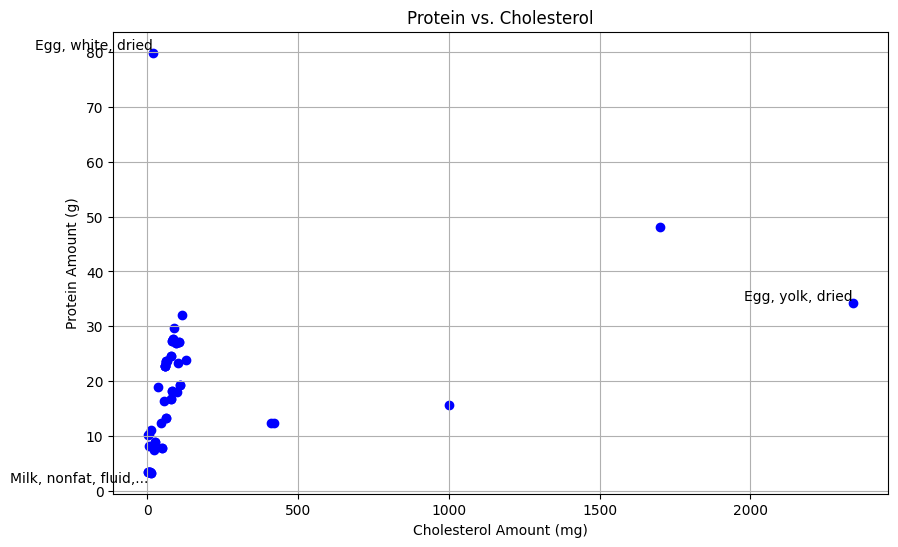

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(cholesterol_protein_df['cholesterolAmount'], cholesterol_protein_df['proteinAmount'], color='blue')

# Find the food with the highest and lowest protein amounts
highest_protein = cholesterol_protein_df[cholesterol_protein_df['proteinAmount'] ==
                                         cholesterol_protein_df['proteinAmount'].max()].iloc[0]


plt.text(highest_protein['cholesterolAmount'], highest_protein['proteinAmount'],
         highest_protein['truncated_description'], fontsize=10, ha='right', va='bottom')


# Repeat the process for cholesterol
highest_cholesterol = cholesterol_protein_df[cholesterol_protein_df['cholesterolAmount'] ==
                                             cholesterol_protein_df['cholesterolAmount'].max()].iloc[0]

lowest_cholesterol = cholesterol_protein_df[cholesterol_protein_df['cholesterolAmount'] ==
                                            cholesterol_protein_df['cholesterolAmount'].min()].iloc[0]

plt.text(highest_cholesterol['cholesterolAmount'], highest_cholesterol['proteinAmount'],
         highest_cholesterol['truncated_description'], fontsize=10, ha='right', va='bottom')

plt.text(lowest_cholesterol['cholesterolAmount'], lowest_cholesterol['proteinAmount'],
         lowest_cholesterol['truncated_description'], fontsize=10, ha='right', va='top')

plt.xlabel('Cholesterol Amount (mg)')
plt.ylabel('Protein Amount (g)')
plt.title('Protein vs. Cholesterol')

plt.grid(True)
plt.show()